# Evacuation Planning Simulation for Suzu City

This notebook implements an evacuation planning simulation for Suzu city (珠洲市) in Ishikawa Prefecture, Japan.

## City Information:
- Population: 13,531 (as of March 2021)
- Households: 6,013
- Population density: 54.6 persons per km²
- Total area: 247.20 km²

## Algorithms Used:
1. **Maximum Flow Problem**: To determine optimal evacuation routes and capacities
2. **Time-Expanded Network**: To model evacuation over time with dynamic constraints
3. **Combinatorial Optimization**: To find the best evacuation plan

## Simulation Components:
- Road network from OpenStreetMap
- Population distribution
- Evacuation shelters/safe zones
- Time-dependent evacuation flow


Libraries imported successfully!
Available CPU cores: 20
Available memory: 10.9 GB
Execution time for load_graph: 2.64s | Memory change: +81.5MB


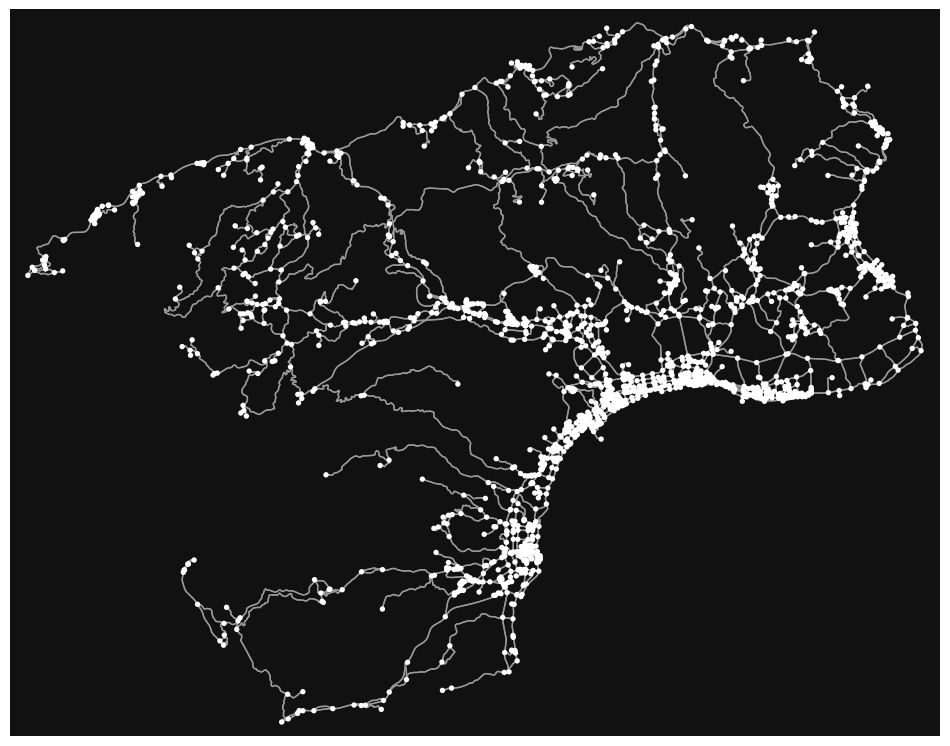

In [15]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Performance monitoring
import time
import psutil
import memory_profiler
from functools import wraps

# Animation and visualization imports
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from IPython.display import HTML, display, clear_output
import matplotlib.patches as patches
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

# Parallel processing optimization
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
from joblib import Parallel, delayed

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Performance monitoring decorator
def monitor_performance(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        start_memory = psutil.Process().memory_info().rss / 1024 / 1024  # MB
        
        result = func(*args, **kwargs)
        
        end_time = time.time()
        end_memory = psutil.Process().memory_info().rss / 1024 / 1024  # MB
        
        print(f"Execution time for {func.__name__}: {end_time - start_time:.2f}s | Memory change: {end_memory - start_memory:+.1f}MB")
        return result
    return wrapper

print("Libraries imported successfully!")
print(f"Available CPU cores: {mp.cpu_count()}")
print(f"Available memory: {psutil.virtual_memory().available / 1024**3:.1f} GB")

place_name = "Suzu, Ishikawa, Japan"

@monitor_performance
def load_graph():
    return ox.graph_from_place(place_name, network_type='drive')

graph = load_graph()
fig, ax = ox.plot_graph(graph, figsize=(12, 10))



In [16]:
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

In [17]:
edges.columns

Index(['osmid', 'highway', 'oneway', 'reversed', 'length', 'bridge',
       'geometry', 'name', 'ref', 'lanes', 'maxspeed', 'tunnel', 'width',
       'est_width', 'access'],
      dtype='object')

In [18]:
# Get nodes and edges as GeoDataFrames
nodes, edges = ox.graph_to_gdfs(graph)

print(f"Network Statistics:")
print(f"Number of nodes: {len(nodes)}")
print(f"Number of edges: {len(edges)}")
print(f"\nNodes columns: {list(nodes.columns)}")
print(f"\nEdges columns: {list(edges.columns)}")

# Check the bounds of the network
bounds = nodes.total_bounds
print(f"\nNetwork bounds (lon_min, lat_min, lon_max, lat_max): {bounds}")
print(edges['length'])


Network Statistics:
Number of nodes: 1861
Number of edges: 5043

Nodes columns: ['y', 'x', 'street_count', 'junction', 'highway', 'geometry']

Edges columns: ['osmid', 'highway', 'oneway', 'reversed', 'length', 'bridge', 'geometry', 'name', 'ref', 'lanes', 'maxspeed', 'tunnel', 'width', 'est_width', 'access']

Network bounds (lon_min, lat_min, lon_max, lat_max): [137.0884597  37.3614715 137.3601281  37.5294151]
u            v            key
1281068967   1281085627   0      475.433891
             1281088757   0      308.617274
             1281093936   0      527.876788
1281068968   1281110312   0       63.387881
             1281147637   0      145.787930
                                    ...    
11554332531  11554332523  0       77.406863
             11491062922  0       24.558301
12193918084  1281126546   0       32.597996
             9572654173   0      181.919245
             1281092623   0       65.842164
Name: length, Length: 5043, dtype: float64


In [19]:
# Evacuation simulation parameters
class EvacuationParameters:
    def __init__(self):
        self.total_population = 13531  
        self.total_households = 6013
        self.city_area_km2 = 247.20
        self.population_density = 54.6
        
        # Evacuation parameters
        self.evacuation_time_limit = 240
        self.time_step = 5  # minutes
        self.walking_speed = 5  # km/h
        self.driving_speed = 30  # km/h
        self.evacuation_modes = ['walking', 'driving']
        
        # Capacity parameters
        self.road_capacity_per_meter = 1  # persons per meter of road width
        self.default_road_width = 5
        
params = EvacuationParameters()
print(f"Evacuation Parameters:")
print(f"Total Population: {params.total_population:,}")
print(f"Evacuation Time Limit: {params.evacuation_time_limit} minutes")
print(f"Time Steps: {params.time_step} minutes")


Evacuation Parameters:
Total Population: 13,531
Evacuation Time Limit: 240 minutes
Time Steps: 5 minutes


In [20]:
# Create population distribution across nodes
def distribute_population(nodes, total_population, method):
    """Distribute population across network nodes"""
    if method == 'random':
        # Randomly distribute population with some nodes having higher density
        weights = np.random.exponential(1, len(nodes))
        weights = weights / weights.sum()
        population = (weights * total_population).astype(int)
        
    elif method == 'central':
        # Higher population in central areas
        center_lon = nodes.geometry.x.mean()
        center_lat = nodes.geometry.y.mean()
        
        distances = np.sqrt((nodes.geometry.x - center_lon)**2 + 
                           (nodes.geometry.y - center_lat)**2)
        weights = 1 / (1 + distances / distances.max())
        weights = weights / weights.sum()
        population = (weights * total_population).astype(int)
    
    return population

# Distribute population
nodes['population'] = distribute_population(nodes, params.total_population, method='random')

# Ensure total population matches
total_assigned = nodes['population'].sum()
if total_assigned != params.total_population:
    diff = params.total_population - total_assigned
    # Add difference to the node with highest population
    max_pop_idx = nodes['population'].idxmax()
    nodes.loc[max_pop_idx, 'population'] += diff

print(f"Population Distribution:")
print(f"Total population assigned: {nodes['population'].sum():,}")
print(f"Max population at single node: {nodes['population'].max():,}")
print(f"Average population per node: {nodes['population'].mean():.1f}")
print(f"Nodes with population > 0: {(nodes['population'] > 0).sum()}")

Population Distribution:
Total population assigned: 13,531
Max population at single node: 979
Average population per node: 7.3
Nodes with population > 0: 1596


In [21]:
# Define real shelter locations (NAME, LONGITUDE, LATITUDE)
shelter_data = [
    ("Misaki Elementary School", 137.3386079 ,37.4865063),
    ("Misaki Junior High School", 137.3421125, 37.4735508),
    ("Misaki Kominkan", 137.3417233 ,37.4741329, ),
    ("Misaki Day service Center", 137.3411659,37.4682916 ),
    ("Former Kodomari Elementary School", 137.3579202 ,37.4512824),
    ("Bishouen", 137.3546414, 37.4550024),
    ("Former Hon Elementary School", 137.3191886, 37.4669704),
    ("Wakayama Elementary School", 137.2380186, 37.4564239),
    ("Wakayama Kominkan", 137.2414873, 37.4567271),
    ("Former Kamikuromaru Elementary School", 137.1675344, 37.4531086),
    ("Naminohana Day Service Center Satellite",  137.1717194, 37.4529168),
    ("Uedo Kominkan", 137.2514576, 37.4275655 ),
    ("Uedo Elementary School",  137.2500348, 37.42733367),
    ("Shoin Kominkan", 137.294170, 37.4441519 ),
    ("Shoin Elementary School", 137.2963972, 37.4455364 ),
    ("Former Iizuka Nursery school",  137.287401, 37.46005),
    ("Hioki Kominkan", 137.2816343, 37.5256146),
    ("Naminohana Day Service Center", 137.1737721, 37.5002642 ),
    ("Otani Sho Junior High School", 137.176221, 37.499813 ),
    ("Otani Kominkan", 137.17389061 ,37.5017345),
    ("Takojima Kominkan", 137.3162568, 37.4429716),
    ("Takojima Elementary School", 137.3135001 ,37.4428631),
    ("Iida Kominkan", 137.2634559, 37.4386061 ),
    ("Iida Elementary School", 137.2595845, 37.44139991),
    ("Horyu Kominkan", 137.239350, 37.4015919),
    ("Horyu Elementary and Junior High School",  137.2377243, 37.4029323),
    ("Daisan Chojuen", 137.239173 ,37.4050800),
    ("Former Horyu Elementary School", 137.236946, 37.3967473),
    ("Chojuen", 137.240152, 37.4113336),
    ("Midorigaoka Junior High School", 137.2822918, 37.4426085),
    ("Tada Elementary School", 137.2816905, 37.4439484),
    ("Tada Kominkan", 137.280125, 37.44379726),
    ("Daini Chojuen", 137.2534331, 37.3449641),
    ("Matsunami Elementary School", 137.2447520, 37.3497276),
    ("Matsunami Junior High School",  137.244516, 37.346722),
    ("Uchiura Gymnasium",  137.2518157, 37.3428780),
    ("Shiromaru Community Facility",  137.2636797, 37.32681930),
    ("Noto Worker Plaza",  137.2345965, 37.3128900),
    ("Ogi Junior High School",  137.2232442, 37.3042909),
    ("Ogi Area Exchange Center",  137.2239980, 37.3006649),
    ("Ogi Elementary School",  137.223728, 37.2992604),
    ("Hime Exchange Center",  137.2125856, 37.29643723),
    ("Takakura Kominkan",  137.20855914, 37.3022237),
    ("Former Mawaki Elementary School",  137.2050652, 37.306543),
    ("Elderly Rest House Tanagisou",  137.1609513, 37.3032503),
    ("Shirasagi Nursery school", 137.1528388, 37.3091604 ),
    ("Children Mirai Center",  137.1487435, 37.30880138),
    ("Ushitsu Elementary School", 137.1461702, 37.3066262),
    ("Noto Gymnasium", 137.1484292, 37.3032023 ),
    ("Hibari Nursery school (Provisional Building)",137.1483707, 37.3024730 ),
    ("Sakiyama Sanson Kaihatsu Center", 137.1486993, 37.3028518),
    ("Noto Junior High School",137.1440288, 37.3025005),
    ("Yanai Tennis Court", 137.13351926, 37.2949099),
    ("Sannami Kominkan", 137.1170012, 37.2891499),
    ("Noto Shichimi Health Welfare no Go Nagomi", 137.0935441, 37.2664550),
    ("Ukawa Elementary School",  137.0830517, 37.2572431),
    ("Ukawa Nursery school",  137.0838109, 37.25452872),
    ("Ukawa Kominkan", 137.0851153, 37.25335004 ),
    ("Omo Kominkan",  137.1139702, 37.3796981),
    ("Yanagida Elementary School", 137.0962415, 37.3665538),
    ("Yanagida Nursery school", 137.0873315, 37.3734405),
    ("Concert Noto", 137.1482760, 37.3101367),
    ("Jinno Kominkan", 137.0839002, 37.3159556),
    ("Mizuho Kominkan", 137.040578,37.2804149),
    ("Yanagida Junior High School", 137.0928745, 37.36575890),
    ("Yanagida Gymnasium", 137.0924464, 37.3687055),
    ("Yanagida Kominkan",137.0958325, 37.36939063),
    ("Kanmachi Kominkan", 137.1088014, 37.3505403),
    ("Iwaido Kominkan", 137.0396952, 37.3648832),
    ("Akiyoshi Kominkan", 137.2387345, 37.3330286),
    ("Ishikawa Prefectural Noto Industry Gijutsu Semmonko", 137.2065864, 37.33772706),
    ("Ishikawa Prefectural Noto High School", 137.1505371, 37.2991115),
    ("Kanmachi Kominkan Goroku Branch Office", 137.1362070, 37.3396300),
    ("Fudoji Kominkan", 137.2097332, 37.3378086),
    ("Matsunami Kominkan", 137.2449241, 37.3535669)
]


# Identify evacuation shelters/safe zones based on predefined coordinates
def identify_evacuation_shelters_from_coords(nodes, predefined_shelters):
    """Identify evacuation shelters by finding the nearest available network node to predefined coordinates."""
    shelter_node_ids = []
    assigned_nodes = set()  # Track already assigned nodes
    
    if not predefined_shelters:
        print("No predefined shelters provided.")
        return []

    print(f"Processing {len(predefined_shelters)} shelters...")
    
    for i, (name, lon, lat) in enumerate(predefined_shelters):
        # Calculate distances to all nodes
        distances = np.sqrt((nodes.geometry.x - lon)**2 + (nodes.geometry.y - lat)**2)
        
        # Sort nodes by distance to find the nearest available one
        sorted_nodes = distances.sort_values()
        
        assigned_node = None
        for node_id in sorted_nodes.index:
            if node_id not in assigned_nodes:
                # Found an unassigned node
                assigned_node = node_id
                break
        
        if assigned_node is not None:
            shelter_node_ids.append(assigned_node)
            assigned_nodes.add(assigned_node)
            # Store shelter name on the node
            nodes.loc[assigned_node, 'shelter_name'] = name
            
            # Calculate distance for reporting
            distance = distances.loc[assigned_node]
            print(f"  {i+1:2d}. '{name}' -> Node {assigned_node} (distance: {distance:.6f})")
        else:
            print(f"  WARNING: Could not find available node for '{name}'")
    
    print(f"Successfully assigned {len(shelter_node_ids)} shelters to unique nodes")
    return shelter_node_ids

# Identify shelters using the predefined list
# You will need to populate `shelter_data` with actual (name, lon, lat) tuples
shelter_nodes = identify_evacuation_shelters_from_coords(nodes, shelter_data)

nodes['is_shelter'] = False
if shelter_nodes:
    nodes.loc[shelter_nodes, 'is_shelter'] = True

print(f"Evacuation Shelters:")
print(f"Number of shelters: {len(shelter_nodes)}")
# If you stored names and want to print them:
# for node_id in shelter_nodes:
# print(f"  Node ID: {node_id}, Name: {nodes.loc[node_id].get('shelter_name', 'N/A')}")
print(f"Shelter node IDs: {shelter_nodes}")


# Add capacity to shelters
nodes['shelter_capacity'] = 0 
if shelter_nodes: # Only assign capacities if shelters were identified
    shelter_capacities = np.random.randint(100, 200, size=len(shelter_nodes))
    nodes.loc[shelter_nodes, 'shelter_capacity'] = shelter_capacities
    print(f"Total shelter capacity: {nodes.loc[shelter_nodes, 'shelter_capacity'].sum():,}")
    print(f"Average shelter capacity: {nodes.loc[shelter_nodes, 'shelter_capacity'].mean():.1f}")
    print(f"Min shelter capacity: {nodes.loc[shelter_nodes, 'shelter_capacity'].min()}")
    print(f"Max shelter capacity: {nodes.loc[shelter_nodes, 'shelter_capacity'].max()}")
else:
    print("No shelters identified, so no capacities assigned.")

print(f"\\nDetailed shelter information:")
if shelter_nodes:
    shelter_info = nodes.loc[shelter_nodes, ['population', 'is_shelter', 'shelter_capacity', 'shelter_name']].copy()
    shelter_info.index.name = 'Node ID'
    print(shelter_info.sort_values('shelter_capacity', ascending=False))
else:
    print("No shelter information to display.")

Processing 75 shelters...
   1. 'Misaki Elementary School' -> Node 3762984021 (distance: 0.001070)
   2. 'Misaki Junior High School' -> Node 11506868426 (distance: 0.001034)
   3. 'Misaki Kominkan' -> Node 1281075355 (distance: 0.000684)
   4. 'Misaki Day service Center' -> Node 1281148941 (distance: 0.000908)
   5. 'Former Kodomari Elementary School' -> Node 1281148891 (distance: 0.000632)
   6. 'Bishouen' -> Node 1281106683 (distance: 0.001176)
   7. 'Former Hon Elementary School' -> Node 11493782008 (distance: 0.001218)
   8. 'Wakayama Elementary School' -> Node 11486765638 (distance: 0.001257)
   9. 'Wakayama Kominkan' -> Node 1281091320 (distance: 0.000389)
  10. 'Former Kamikuromaru Elementary School' -> Node 11476114070 (distance: 0.000279)
  11. 'Naminohana Day Service Center Satellite' -> Node 1281088408 (distance: 0.003097)
  12. 'Uedo Kominkan' -> Node 1281091172 (distance: 0.000735)
  13. 'Uedo Elementary School' -> Node 1281076637 (distance: 0.000436)
  14. 'Shoin Kominkan

In [22]:
# Calculate edge capacities and travel times
def calculate_edge_properties(edges, params):
    """Calculate capacity and travel time for each edge"""
    # Convert to numeric values, handling string values
    width_series = pd.to_numeric(edges['width'], errors='coerce')
    est_width_series = pd.to_numeric(edges['est_width'], errors='coerce')
    edges['width_calc'] = width_series.fillna(est_width_series).fillna(params.default_road_width)
    
    # Calculate capacity based on road width and length
    edges['capacity'] = (edges['width_calc'] * edges['length'] * params.road_capacity_per_meter / 100).astype(int)
    edges['capacity'] = edges['capacity'].clip(lower=10)  # Ensure minimum capacity of 10   
    
    # Calculate travel times (in minutes)
    # Walking time
    edges['walk_time'] = (edges['length'] / 1000) / params.walking_speed * 60  # minutes
    
    # Driving time (use maxspeed if available)
    max_speeds = edges['maxspeed'].fillna(params.driving_speed)
    # Convert string speeds to numeric
    max_speeds = pd.to_numeric(max_speeds, errors='coerce').fillna(params.driving_speed)
    edges['drive_time'] = (edges['length'] / 1000) / max_speeds * 60  # minutes
    
    return edges

# Calculate edge properties
edges = calculate_edge_properties(edges, params)

print(f"Edge Properties:")
print(f"Capacity - Min: {edges['capacity'].min()}, Max: {edges['capacity'].max()}, Mean: {edges['capacity'].mean():.1f}")
print(f"Walk time - Min: {edges['walk_time'].min():.2f}, Max: {edges['walk_time'].max():.2f} minutes")
print(f"Drive time - Min: {edges['drive_time'].min():.2f}, Max: {edges['drive_time'].max():.2f} minutes")

Edge Properties:
Capacity - Min: 10, Max: 280, Mean: 15.6
Walk time - Min: 0.01, Max: 67.27 minutes
Drive time - Min: 0.00, Max: 11.21 minutes


In [23]:
# Add west exit point to the evacuation network
def add_west_exit(nodes, edges, graph):
    """Add a west exit point for evacuation"""
    # Find the westernmost area of the city
    west_lon = nodes.geometry.x.min()
    lon_range = nodes.geometry.x.max() - nodes.geometry.x.min()
    west_threshold = west_lon + (lon_range * 0.15)
    
    # Get nodes in the western area
    west_nodes = nodes[nodes.geometry.x <= west_threshold]
    
    # Select the westernmost node as the exit point
    west_exit_node = west_nodes.geometry.x.idxmin()
    
    # Mark this node as a west exit
    nodes.loc[west_exit_node, 'is_west_exit'] = True
    nodes.loc[west_exit_node, 'exit_capacity'] = 100000
    
    print(f"West exit created at node {west_exit_node}")
    print(f"Exit location: ({nodes.loc[west_exit_node, 'geometry'].x:.4f}, {nodes.loc[west_exit_node, 'geometry'].y:.4f})")
    
    return west_exit_node

# Initialize exit columns if they don't exist
if 'is_west_exit' not in nodes.columns:
    nodes['is_west_exit'] = False
if 'exit_capacity' not in nodes.columns:
    nodes['exit_capacity'] = 0

def add_south_exit(nodes, edges, graph):
    """Add a south exit point for evacuation, using latitude between 37.4 and 37.45 and longitude between 137.15 and 137.2"""

    south_nodes = nodes[(nodes.geometry.y >= 37.4) & (nodes.geometry.y <= 37.45) & (nodes.geometry.x >= 137.15) & (nodes.geometry.x <= 137.2)]
    
    if south_nodes.empty:
        raise ValueError("No nodes found in the latitude range 37.4 to 37.45")
    
    # Select the southernmost node within this range
    south_exit_node = south_nodes.geometry.y.idxmin()
    
    # Mark this node as a south exit
    nodes.loc[south_exit_node, 'is_south_exit'] = True
    nodes.loc[south_exit_node, 'exit_capacity'] = 100000
    
    print(f"South exit created at node {south_exit_node}")
    print(f"Exit location: ({nodes.loc[south_exit_node, 'geometry'].x:.4f}, {nodes.loc[south_exit_node, 'geometry'].y:.4f})")
    
    return south_exit_node

def add_west_south_exit(nodes, edges, graph):
    """Add a west-south exit point for evacuation in the southwestern area"""
    #
    west_lon = nodes.geometry.x.min()
    south_lat = nodes.geometry.y.min()
    
    lon_range = nodes.geometry.x.max() - nodes.geometry.x.min()
    lat_range = nodes.geometry.y.max() - nodes.geometry.y.min()
    
    west_threshold = west_lon + (lon_range * 0.15) 
    south_threshold = south_lat + (lat_range * 0.15) + 0.07
    print(f"West-South exit thresholds: West {west_threshold:.4f}, South {south_threshold:.4f}")
    
    # Get nodes in the southwestern area
    southwest_nodes = nodes[
        (nodes.geometry.x >= west_threshold) & 
        (nodes.geometry.y >= south_threshold)
    ]
    
    if len(southwest_nodes) == 0:
        # If no nodes in the strict southwestern area, expand the search
        west_threshold = west_lon + (lon_range * 0.15) 
        south_threshold = south_lat + (lat_range * 0.15) + 0.07
        southwest_nodes = nodes[
            (nodes.geometry.x >= west_threshold) & 
            (nodes.geometry.y >= south_threshold)
        ]
    print(f"Southwest nodes found: {len(southwest_nodes)}")
    # Select the node that is closest to the southwest corner
    if len(southwest_nodes) > 0:
        # Calculate distance to southwest corner
        distances = np.sqrt(
            (southwest_nodes.geometry.x - west_lon)**2 + (southwest_nodes.geometry.y - south_lat)**2
        )
        west_south_exit_node = distances.idxmin()
    else:
        # Fallback: select the westernmost node among the southernmost nodes
        south_nodes = nodes[nodes.geometry.y <= south_lat + (lat_range * 2)] 
        west_south_exit_node = south_nodes.geometry.x.idxmin()
    
    # Mark this node as a west-south exit
    nodes.loc[west_south_exit_node, 'is_west_south_exit'] = True
    nodes.loc[west_south_exit_node, 'exit_capacity'] = 100000
    
    print(f"West-South exit created at node {west_south_exit_node}")
    print(f"Exit location: ({nodes.loc[west_south_exit_node, 'geometry'].x:.4f}, {nodes.loc[west_south_exit_node, 'geometry'].y:.4f})")
    
    return west_south_exit_node

# Initialize exit columns if they don't exist
if 'is_south_exit' not in nodes.columns:
    nodes['is_south_exit'] = False
if 'is_west_south_exit' not in nodes.columns:
    nodes['is_west_south_exit'] = False
if 'exit_capacity' not in nodes.columns:
    nodes['exit_capacity'] = 0

add_west_exit(nodes, edges, graph)
add_south_exit(nodes, edges, graph)
add_west_south_exit(nodes, edges, graph)


West exit created at node 1281123728
Exit location: (137.0885, 37.4693)
South exit created at node 1281108573
Exit location: (137.1791, 37.4212)
West-South exit thresholds: West 137.1292, South 37.4567
Southwest nodes found: 802
West-South exit created at node 1281090837
Exit location: (137.1333, 37.4636)


np.int64(1281090837)

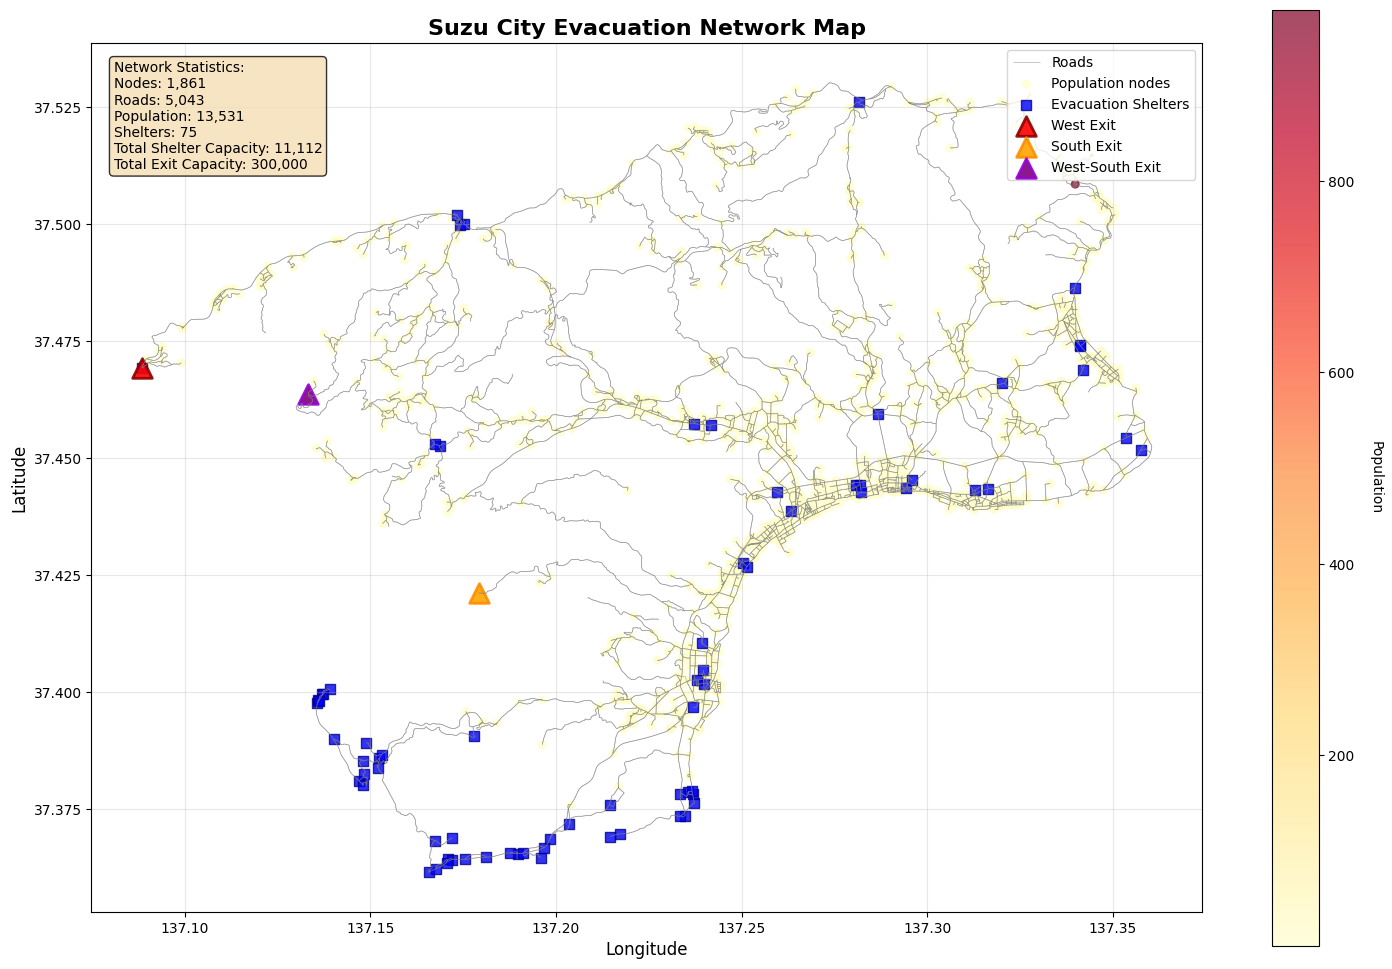

In [24]:
# Create a comprehensive map showing the evacuation network
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Plot the road network
edges.plot(ax=ax, linewidth=0.5, alpha=0.6, color='gray', label='Roads')

# Plot all nodes with population
nodes_with_pop = nodes[nodes['population'] > 0]
scatter = ax.scatter(nodes_with_pop.geometry.x, nodes_with_pop.geometry.y, 
                                        c=nodes_with_pop['population'], cmap='YlOrRd', 
                                        s=30, alpha=0.7, label='Population nodes')

# Plot evacuation shelters
shelter_nodes_data = nodes[nodes['is_shelter']]
ax.scatter(shelter_nodes_data.geometry.x, shelter_nodes_data.geometry.y, 
                  c='blue', s=50, marker='s', alpha=0.8, label='Evacuation Shelters', 
                  edgecolors='darkblue', linewidth=1)

# Plot west exit
west_exit_data = nodes[nodes['is_west_exit']]
ax.scatter(west_exit_data.geometry.x, west_exit_data.geometry.y, 
                  c='red', s=200, marker='^', alpha=0.9, label='West Exit', 
                  edgecolors='darkred', linewidth=2)

# Plot south exit
south_exit_data = nodes[nodes['is_south_exit']]
ax.scatter(south_exit_data.geometry.x, south_exit_data.geometry.y, 
                  c='orange', s=200, marker='^', alpha=0.9, label='South Exit', 
                  edgecolors='darkorange', linewidth=2)

# Plot west-south exit
west_south_exit_data = nodes[nodes['is_west_south_exit']]
ax.scatter(west_south_exit_data.geometry.x, west_south_exit_data.geometry.y, 
                  c='purple', s=200, marker='^', alpha=0.9, label='West-South Exit', 
                  edgecolors='darkviolet', linewidth=2)

# Add colorbar for population
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label('Population', rotation=270, labelpad=20)

# Add title and labels
ax.set_title('Suzu City Evacuation Network Map', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Add grid
ax.grid(True, alpha=0.3)

# Calculate correct exit capacities
total_exit_capacity = nodes[nodes['is_west_exit'] | nodes['is_south_exit'] | nodes['is_west_south_exit']]['exit_capacity'].sum()

# Add statistics text box
stats_text = f"""Network Statistics:
Nodes: {len(nodes):,}
Roads: {len(edges):,}
Population: {nodes['population'].sum():,}
Shelters: {len(shelter_nodes)}
Total Shelter Capacity: {nodes['shelter_capacity'].sum():,}
Total Exit Capacity: {total_exit_capacity:,}"""

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()


In [25]:

from networkx.algorithms.flow import shortest_augmenting_path

G = nx.DiGraph()
G.add_nodes_from(nodes.index)
for idx, row in edges.iterrows():
    # idx is a tuple: (u, v, key)
    u, v = idx[0], idx[1]
    G.add_edge(u, v, 
               capacity=row['capacity'], 
               walk_time=row['walk_time'], 
               drive_time=row['drive_time'],
               length=row['length'])
    
# Add shelter and exit attributes to nodes
for node_id in nodes.index:
    G.nodes[node_id]['population'] = nodes.loc[node_id, 'population']
    G.nodes[node_id]['is_shelter'] = nodes.loc[node_id, 'is_shelter']
    G.nodes[node_id]['shelter_capacity'] = nodes.loc[node_id, 'shelter_capacity']
    G.nodes[node_id]['is_west_exit'] = nodes.loc[node_id, 'is_west_exit']
    G.nodes[node_id]['is_south_exit'] = nodes.loc[node_id, 'is_south_exit']
    G.nodes[node_id]['is_west_south_exit'] = nodes.loc[node_id, 'is_west_south_exit']
    G.nodes[node_id]['exit_capacity'] = nodes.loc[node_id, 'exit_capacity']


def calculate_max_flow(G, source, target):
    """Calculate maximum flow from source to target using the shortest augmenting path algorithm."""
    flow_value, flow_dict = nx.maximum_flow(G, source=source, target=target, flow_func=shortest_augmenting_path)
    return flow_value, flow_dict
def find_shelter_for_population(G, population):
    """Find the best shelter for a given population based on available capacity."""
    shelters = [n for n in G.nodes if G.nodes[n].get('is_shelter', False)]
    shelter_capacities = {s: G.nodes[s]['shelter_capacity'] for s in shelters}
    
    # Sort shelters by capacity
    sorted_shelters = sorted(shelter_capacities.items(), key=lambda x: x[1], reverse=True)
    
    total_capacity = 0
    selected_shelters = []
    
    for shelter, capacity in sorted_shelters:
        if total_capacity >= population:
            break
        selected_shelters.append(shelter)
        total_capacity += capacity
    
    return selected_shelters, total_capacity



In [26]:
class TimeExpandedNetwork:
    """
    Time-Expanded Network for evacuation planning.
    Creates a layered network where each layer represents a time step.
    """
    
    def __init__(self, base_graph, time_steps, time_step_duration):
        self.base_graph = base_graph
        self.time_steps = time_steps
        self.time_step_duration = time_step_duration  # in minutes
        self.time_expanded_graph = nx.DiGraph()
        self.node_mapping = {}  # Maps (original_node, time) to time_expanded_node
        self.reverse_mapping = {}  # Maps time_expanded_node to (original_node, time)
        
    def build_time_expanded_network(self):
        """Build the time-expanded network."""
        print(f"Building time-expanded network with {self.time_steps} time steps...")
        
        # Create nodes for each time layer
        node_counter = 0
        for t in range(self.time_steps):
            for original_node in self.base_graph.nodes():
                time_expanded_node = f"n_{original_node}_t_{t}"
                self.time_expanded_graph.add_node(time_expanded_node)
                
                # Store mapping
                self.node_mapping[(original_node, t)] = time_expanded_node
                self.reverse_mapping[time_expanded_node] = (original_node, t)
                
                # Copy node attributes
                for attr, value in self.base_graph.nodes[original_node].items():
                    self.time_expanded_graph.nodes[time_expanded_node][attr] = value
                
                # Add time attribute
                self.time_expanded_graph.nodes[time_expanded_node]['time'] = t
                node_counter += 1
        
        print(f"Created {node_counter} time-expanded nodes")
        
        # Create edges between time layers
        edge_counter = 0
        for t in range(self.time_steps - 1):
            for u, v, edge_data in self.base_graph.edges(data=True):
                # Calculate travel time in time steps
                walk_time_steps = int(np.ceil(edge_data['walk_time'] / self.time_step_duration))
                drive_time_steps = int(np.ceil(edge_data['drive_time'] / self.time_step_duration))
                
                # Add walking edge (use walk_time)
                if t + walk_time_steps < self.time_steps:
                    source_node = self.node_mapping[(u, t)]
                    target_node = self.node_mapping[(v, t + walk_time_steps)]
                    
                    self.time_expanded_graph.add_edge(
                        source_node, target_node,
                        capacity=edge_data['capacity'],
                        travel_mode='walk',
                        travel_time=walk_time_steps,
                        original_edge=(u, v)
                    )
                    edge_counter += 1
                
                # Add driving edge (use drive_time)
                if t + drive_time_steps < self.time_steps:
                    source_node = self.node_mapping[(u, t)]
                    target_node = self.node_mapping[(v, t + drive_time_steps)]
                    
                    self.time_expanded_graph.add_edge(
                        source_node, target_node,
                        capacity=edge_data['capacity'] * 2,  # Higher capacity for driving
                        travel_mode='drive',
                        travel_time=drive_time_steps,
                        original_edge=(u, v)
                    )
                    edge_counter += 1
        
        # Add holding edges (staying at the same location)
        for t in range(self.time_steps - 1):
            for original_node in self.base_graph.nodes():
                source_node = self.node_mapping[(original_node, t)]
                target_node = self.node_mapping[(original_node, t + 1)]
                
                # Large capacity for holding (people can wait)
                self.time_expanded_graph.add_edge(
                    source_node, target_node,
                    capacity=10000,
                    travel_mode='hold',
                    travel_time=1,
                    original_edge=(original_node, original_node)
                )
                edge_counter += 1
        
        print(f"Created {edge_counter} time-expanded edges")
        return self.time_expanded_graph
    
    def add_evacuation_demand(self, population_nodes, evacuation_targets):
        """Add super source and super sink for evacuation flow."""
        # Add super source
        super_source = "super_source"
        self.time_expanded_graph.add_node(super_source)
        
        # Connect super source to population nodes at time 0
        for node_id, population in population_nodes.items():
            if population > 0:
                start_node = self.node_mapping[(node_id, 0)]
                self.time_expanded_graph.add_edge(
                    super_source, start_node,
                    capacity=population,
                    travel_mode='source',
                    travel_time=0
                )
        
        # Add super sink
        super_sink = "super_sink"
        self.time_expanded_graph.add_node(super_sink)
        
        # Connect evacuation targets to super sink for all time steps
        for t in range(self.time_steps):
            for target_node in evacuation_targets:
                time_target = self.node_mapping[(target_node, t)]
                # Use the original node's capacity if it's an exit or shelter
                original_capacity = self.base_graph.nodes[target_node].get('exit_capacity', 0)
                if original_capacity == 0:
                    original_capacity = self.base_graph.nodes[target_node].get('shelter_capacity', 0)
                
                self.time_expanded_graph.add_edge(
                    time_target, super_sink,
                    capacity=original_capacity,
                    travel_mode='sink',
                    travel_time=0
                )
        
        return super_source, super_sink

def solve_evacuation_problem(base_graph, nodes_data, time_limit_minutes, time_step_minutes):
    """
    Solve the evacuation problem using time-expanded network and maximum flow.
    """
    print(f"Solving evacuation problem with {time_limit_minutes} minute time limit")
    
    # Calculate number of time steps
    time_steps = int(time_limit_minutes / time_step_minutes) + 1
    print(f"Time steps: {time_steps}")
    
    # Create time-expanded network
    ten = TimeExpandedNetwork(base_graph, time_steps, time_step_minutes)
    time_graph = ten.build_time_expanded_network()
    
    # Get population distribution
    population_nodes = {idx: row['population'] for idx, row in nodes_data.iterrows() if row['population'] > 0}
    total_population = sum(population_nodes.values())
    print(f"Total population to evacuate: {total_population:,}")
    
    # Get evacuation targets (shelters and exits)
    evacuation_targets = []
    for idx, row in nodes_data.iterrows():
        if (row.get('is_shelter', False) or 
            row.get('is_west_exit', False) or 
            row.get('is_south_exit', False) or 
            row.get('is_west_south_exit', False)):
            evacuation_targets.append(idx)
    
    print(f"Evacuation targets: {len(evacuation_targets)} (shelters + exits)")
    
    # Add evacuation demand
    super_source, super_sink = ten.add_evacuation_demand(population_nodes, evacuation_targets)
    
    # Solve maximum flow
    print("Calculating maximum evacuation flow...")
    start_time = time.time()
    
    try:
        flow_value, flow_dict = nx.maximum_flow(
            time_graph, super_source, super_sink, 
            flow_func=shortest_augmenting_path
        )
        
        solve_time = time.time() - start_time
        print(f"Maximum flow calculation completed in {solve_time:.2f} seconds")
        
        # Analyze results
        evacuation_rate = (flow_value / total_population) * 100
        print(f"\nEvacuation Results:")
        print(f"Maximum evacuated population: {flow_value:,}")
        print(f"Total population: {total_population:,}")
        print(f"Evacuation rate: {evacuation_rate:.1f}%")
        
        if evacuation_rate >= 99.9:
            print("SUCCESS: Nearly all population can be evacuated within time limit")
        elif evacuation_rate >= 90:
            print("PARTIAL SUCCESS: Most population can be evacuated")
        else:
            print("WARNING: Significant evacuation capacity shortage")
        
        return {
            'flow_value': flow_value,
            'flow_dict': flow_dict,
            'evacuation_rate': evacuation_rate,
            'time_expanded_network': ten,
            'solve_time': solve_time,
            'total_population': total_population
        }
        
    except Exception as e:
        print(f"Error in maximum flow calculation: {e}")
        return None

def analyze_evacuation_flow(result, time_step_minutes=5):
    """Analyze the evacuation flow results."""
    if result is None:
        print("No results to analyze")
        return
    
    flow_dict = result['flow_dict']
    ten = result['time_expanded_network']
    
    print("\nAnalyzing evacuation flow patterns...")
    
    # Track flow by time step
    flow_by_time = {}
    evacuation_completion = {}
    
    # Analyze flow to sink (evacuated people)
    super_sink = "super_sink"
    total_evacuated_by_time = {}
    
    for source_node, targets in flow_dict.items():
        if super_sink in targets and targets[super_sink] > 0:
            # This is flow into the sink
            if source_node in ten.reverse_mapping:
                original_node, time_step = ten.reverse_mapping[source_node]
                if time_step not in total_evacuated_by_time:
                    total_evacuated_by_time[time_step] = 0
                total_evacuated_by_time[time_step] += targets[super_sink]
    
    # Calculate cumulative evacuation
    cumulative_evacuated = 0
    print("\nEvacuation Timeline:")
    for t in sorted(total_evacuated_by_time.keys()):
        cumulative_evacuated += total_evacuated_by_time[t]
        time_minutes = t * time_step_minutes
        evacuation_percentage = (cumulative_evacuated / result['total_population']) * 100
        print(f"Time {time_minutes:3d} min: {total_evacuated_by_time[t]:4d} evacuated "

              f"(Total: {cumulative_evacuated:5d}, {evacuation_percentage:5.1f}%)")
    
    return total_evacuated_by_time

# Run the evacuation simulation
print("Starting evacuation simulation with time-expanded network...")
evacuation_result = solve_evacuation_problem(G, nodes, time_limit_minutes=params.evacuation_time_limit, time_step_minutes=params.time_step)

if evacuation_result:
    print("\n" + "="*60)
    print("EVACUATION SIMULATION COMPLETED")
    print("="*60)
    
    # Analyze the flow
    flow_timeline = analyze_evacuation_flow(evacuation_result, params.time_step)
    
    # Additional analysis
    print(f"\nSimulation Parameters:")
    print(f"Time limit: {params.evacuation_time_limit} minutes")
    print(f"Time step: {params.time_step} minutes")
    print(f"Walking speed: {params.walking_speed} km/h")
    print(f"Driving speed: {params.driving_speed} km/h")
    print(f"Total shelters: {len(nodes[nodes['is_shelter']])}")
    print(f"Total exits: {len(nodes[nodes['is_west_exit'] | nodes['is_south_exit'] | nodes['is_west_south_exit']])}")
else:
    print("Evacuation simulation failed")

Starting evacuation simulation with time-expanded network...
Solving evacuation problem with 240 minute time limit
Time steps: 49
Building time-expanded network with 49 time steps...
Created 91189 time-expanded nodes
Created 563252 time-expanded edges
Total population to evacuate: 13,531
Evacuation targets: 77 (shelters + exits)
Calculating maximum evacuation flow...
Maximum flow calculation completed in 3.02 seconds

Evacuation Results:
Maximum evacuated population: 13,531
Total population: 13,531
Evacuation rate: 100.0%
SUCCESS: Nearly all population can be evacuated within time limit

EVACUATION SIMULATION COMPLETED

Analyzing evacuation flow patterns...

Evacuation Timeline:
Time   0 min:  506 evacuated (Total:   506,   3.7%)
Time   5 min:  410 evacuated (Total:   916,   6.8%)
Time  10 min:  596 evacuated (Total:  1512,  11.2%)
Time  15 min:  740 evacuated (Total:  2252,  16.6%)
Time  20 min:  858 evacuated (Total:  3110,  23.0%)
Time  25 min:  958 evacuated (Total:  4068,  30.1%)


Creating evacuation result visualizations...


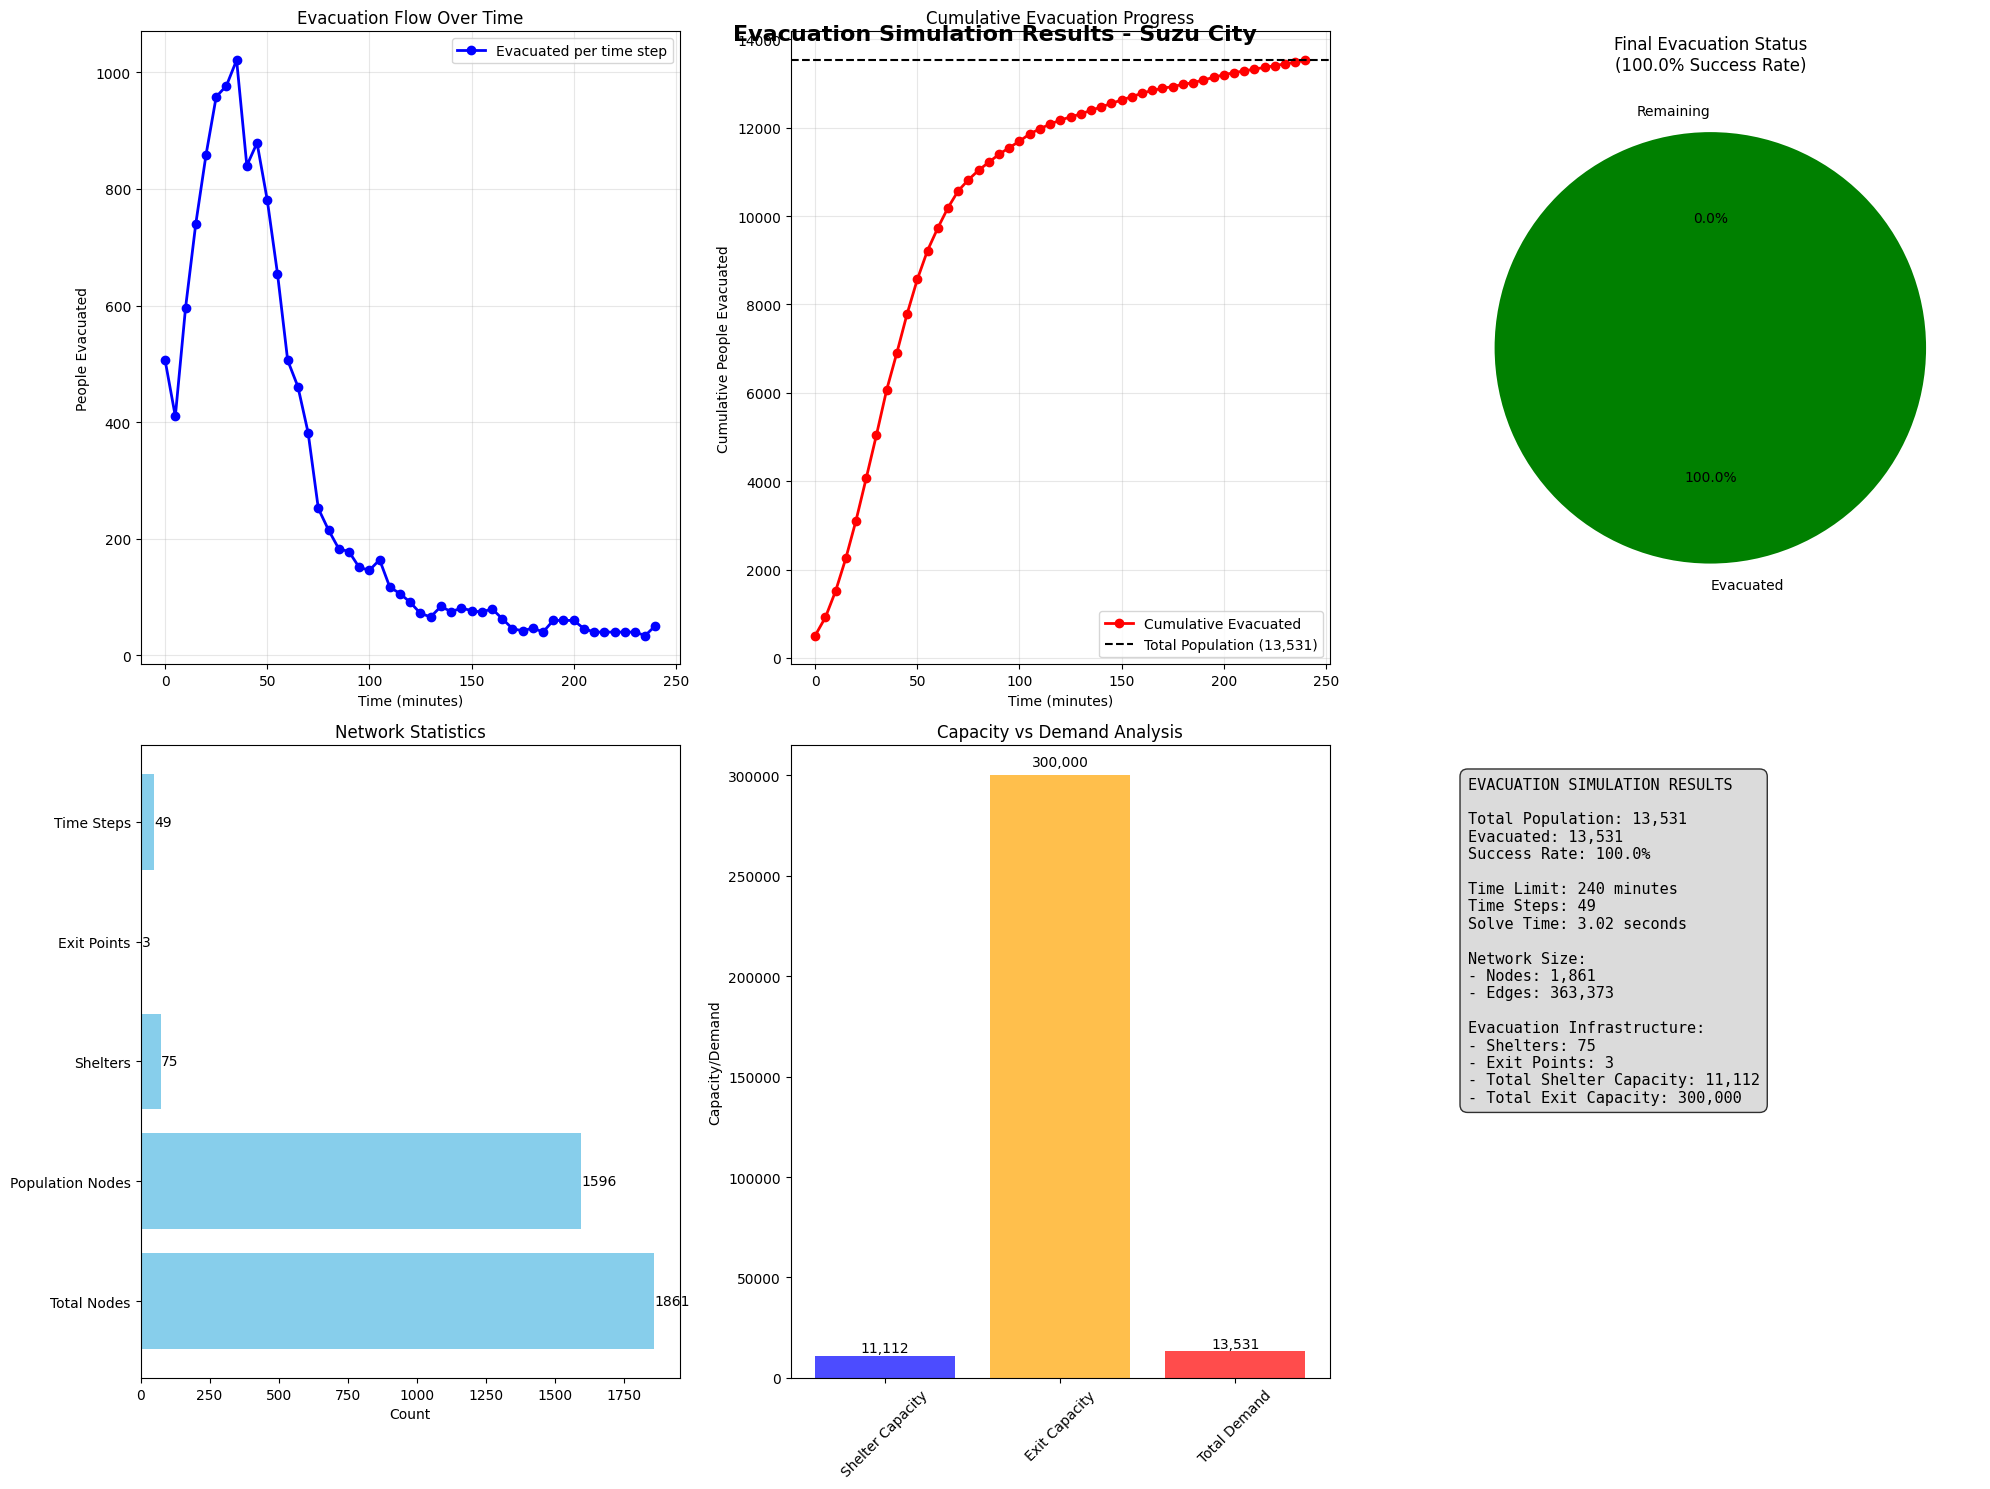

In [27]:
def visualize_evacuation_results(evacuation_result, nodes_data, flow_timeline, params):
    """Create comprehensive visualizations of evacuation results."""
    if evacuation_result is None:
        print("No results to visualize")
        return
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Evacuation Timeline
    ax1 = plt.subplot(2, 3, 1)
    if flow_timeline:
        times = [t * params.time_step for t in sorted(flow_timeline.keys())]
        flows = [flow_timeline[t // params.time_step] for t in times if t // params.time_step in flow_timeline]
        cumulative = np.cumsum(flows)
        
        ax1.plot(times, flows, 'bo-', label='Evacuated per time step', linewidth=2, markersize=6)
        ax1.set_xlabel('Time (minutes)')
        ax1.set_ylabel('People Evacuated')
        ax1.set_title('Evacuation Flow Over Time')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
    
    # 2. Cumulative Evacuation
    ax2 = plt.subplot(2, 3, 2)
    if flow_timeline:
        ax2.plot(times, cumulative, 'ro-', label='Cumulative Evacuated', linewidth=2, markersize=6)
        ax2.axhline(y=evacuation_result['total_population'], color='k', linestyle='--', 
                   label=f"Total Population ({evacuation_result['total_population']:,})")
        ax2.set_xlabel('Time (minutes)')
        ax2.set_ylabel('Cumulative People Evacuated')
        ax2.set_title('Cumulative Evacuation Progress')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
    
    # 3. Evacuation Rate Comparison
    ax3 = plt.subplot(2, 3, 3)
    categories = ['Evacuated', 'Remaining']
    values = [evacuation_result['flow_value'], 
             evacuation_result['total_population'] - evacuation_result['flow_value']]
    colors = ['green', 'red']
    
    wedges, texts, autotexts = ax3.pie(values, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
    ax3.set_title(f"Final Evacuation Status\n({evacuation_result['evacuation_rate']:.1f}% Success Rate)")
    
    # 4. Network Statistics
    ax4 = plt.subplot(2, 3, 4)
    stats_data = {
        'Total Nodes': len(nodes_data),
        'Population Nodes': len(nodes_data[nodes_data['population'] > 0]),
        'Shelters': len(nodes_data[nodes_data['is_shelter']]),
        'Exit Points': len(nodes_data[nodes_data['is_west_exit'] | nodes_data['is_south_exit'] | nodes_data['is_west_south_exit']]),
        'Time Steps': evacuation_result['time_expanded_network'].time_steps
    }
    
    y_pos = np.arange(len(stats_data))
    ax4.barh(y_pos, list(stats_data.values()), color='skyblue')
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels(list(stats_data.keys()))
    ax4.set_xlabel('Count')
    ax4.set_title('Network Statistics')
    
    # Add value labels on bars
    for i, v in enumerate(stats_data.values()):
        ax4.text(v + 0.1, i, str(v), va='center')
    
    # 5. Capacity Analysis
    ax5 = plt.subplot(2, 3, 5)
    shelter_capacity = nodes_data[nodes_data['is_shelter']]['shelter_capacity'].sum()
    exit_capacity = nodes_data[nodes_data['is_west_exit'] | nodes_data['is_south_exit'] | nodes_data['is_west_south_exit']]['exit_capacity'].sum()
    total_demand = evacuation_result['total_population']
    
    capacity_data = {
        'Shelter Capacity': shelter_capacity,
        'Exit Capacity': exit_capacity,
        'Total Demand': total_demand
    }
    
    bars = ax5.bar(capacity_data.keys(), capacity_data.values(), 
                  color=['blue', 'orange', 'red'], alpha=0.7)
    ax5.set_ylabel('Capacity/Demand')
    ax5.set_title('Capacity vs Demand Analysis')
    ax5.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, capacity_data.values()):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + value*0.01,
                f'{value:,}', ha='center', va='bottom')
    
    # 6. Performance Metrics
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    metrics_text = f"""EVACUATION SIMULATION RESULTS

Total Population: {evacuation_result['total_population']:,}
Evacuated: {evacuation_result['flow_value']:,}
Success Rate: {evacuation_result['evacuation_rate']:.1f}%

Time Limit: {params.evacuation_time_limit} minutes
Time Steps: {evacuation_result['time_expanded_network'].time_steps}
Solve Time: {evacuation_result['solve_time']:.2f} seconds

Network Size:
- Nodes: {len(nodes_data):,}
- Edges: {len(evacuation_result['time_expanded_network'].time_expanded_graph.edges()):,}

Evacuation Infrastructure:
- Shelters: {len(nodes_data[nodes_data['is_shelter']])} 
- Exit Points: {len(nodes_data[nodes_data['is_west_exit'] | nodes_data['is_south_exit'] | nodes_data['is_west_south_exit']])}
- Total Shelter Capacity: {shelter_capacity:,}
- Total Exit Capacity: {exit_capacity:,}"""
    
    ax6.text(0.05, 0.95, metrics_text, transform=ax6.transAxes, fontsize=11,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle(f'Evacuation Simulation Results - Suzu City', fontsize=16, fontweight='bold', y=0.98)
    plt.show()

def create_interactive_evacuation_map(nodes_data, evacuation_result):
    """Create an interactive map showing evacuation results."""
    if evacuation_result is None:
        print("No results to map")
        return
    
    # Create interactive plotly map
    fig = go.Figure()
    
    # Add population nodes
    pop_nodes = nodes_data[nodes_data['population'] > 0]
    fig.add_trace(go.Scattermapbox(
        lat=pop_nodes.geometry.y,
        lon=pop_nodes.geometry.x,
        mode='markers',
        marker=dict(
            size=pop_nodes['population']/50,
            color='red',
            opacity=0.6
        ),
        text=[f'Population: {pop}' for pop in pop_nodes['population']],
        name='Population Centers',
        hovertemplate='<b>Node ID:</b> %{text}<br><extra></extra>'
    ))
    
    # Add shelters
    shelters = nodes_data[nodes_data['is_shelter']]
    fig.add_trace(go.Scattermapbox(
        lat=shelters.geometry.y,
        lon=shelters.geometry.x,
        mode='markers',
        marker=dict(
            size=12,
            color='blue',
            symbol='circle'
        ),
        text=[f'Shelter Capacity: {cap}' for cap in shelters['shelter_capacity']],
        name='Evacuation Shelters',
        hovertemplate='<b>Shelter</b><br>%{text}<br><extra></extra>'
    ))
    
    # Add exit points
    exits = nodes_data[nodes_data['is_west_exit'] | nodes_data['is_south_exit'] | nodes_data['is_west_south_exit']]
    fig.add_trace(go.Scattermapbox(
        lat=exits.geometry.y,
        lon=exits.geometry.x,
        mode='markers',
        marker=dict(
            size=15,
            color='green',
            symbol='circle'
        ),
        text=[f'Exit Capacity: {cap}' for cap in exits['exit_capacity']],
        name='Exit Points',
        hovertemplate='<b>Exit Point</b><br>%{text}<br><extra></extra>'
    ))
    
    # Update layout
    center_lat = nodes_data.geometry.y.mean()
    center_lon = nodes_data.geometry.x.mean()
    
    fig.update_layout(
        mapbox=dict(
            style='open-street-map',
            center=dict(lat=center_lat, lon=center_lon),
            zoom=10
        ),
        title=f'Suzu City Evacuation Network - {evacuation_result["evacuation_rate"]:.1f}% Success Rate',
        showlegend=True,
        height=600
    )
    
    fig.show()

# Create visualizations if evacuation was successful
if evacuation_result:
    print("Creating evacuation result visualizations...")
    visualize_evacuation_results(evacuation_result, nodes, flow_timeline, params)
    create_interactive_evacuation_map(nodes, evacuation_result)
else:
    print("Cannot create visualizations - no evacuation results available")

In [28]:
def analyze_evacuation_bottlenecks(evacuation_result, nodes_data, edges_data):
    """Analyze bottlenecks and provide optimization recommendations."""
    if evacuation_result is None:
        print("No results to analyze for bottlenecks")
        return
    
    print("\n" + "="*60)
    print("EVACUATION BOTTLENECK ANALYSIS")
    print("="*60)
    
    flow_dict = evacuation_result['flow_dict']
    ten = evacuation_result['time_expanded_network']
    
    # Analyze edge utilization
    edge_utilization = {}
    for source, targets in flow_dict.items():
        for target, flow in targets.items():
            if flow > 0 and source in ten.time_expanded_graph and target in ten.time_expanded_graph:
                if ten.time_expanded_graph.has_edge(source, target):
                    edge_data = ten.time_expanded_graph[source][target]
                    capacity = edge_data.get('capacity', 1)
                    utilization = flow / capacity if capacity > 0 else 0
                    edge_utilization[(source, target)] = {
                        'flow': flow,
                        'capacity': capacity,
                        'utilization': utilization,
                        'travel_mode': edge_data.get('travel_mode', 'unknown')
                    }
    
    # Find highly utilized edges (bottlenecks)
    bottlenecks = [(edge, data) for edge, data in edge_utilization.items() 
                  if data['utilization'] > 0.8 and data['travel_mode'] not in ['hold', 'source', 'sink']]
    
    bottlenecks.sort(key=lambda x: x[1]['utilization'], reverse=True)
    
    print(f"\nBottleneck Analysis (utilization > 80%):")
    print(f"Found {len(bottlenecks)} highly utilized edges")
    
    if bottlenecks:
        print("\nTop 10 Bottlenecks:")
        for i, (edge, data) in enumerate(bottlenecks[:10]):
            source, target = edge
            print(f"{i+1:2d}. Utilization: {data['utilization']*100:5.1f}% "

                  f"(Flow: {data['flow']:4.0f}/{data['capacity']:4.0f}) "

                  f"Mode: {data['travel_mode']}")
    
    # Analyze capacity distribution
    total_shelter_capacity = nodes_data[nodes_data['is_shelter']]['shelter_capacity'].sum()
    total_exit_capacity = nodes_data[
        nodes_data['is_west_exit'] | nodes_data['is_south_exit'] | nodes_data['is_west_south_exit']
    ]['exit_capacity'].sum()
    
    print(f"\nCapacity Analysis:")
    print(f"Total Shelter Capacity: {total_shelter_capacity:,}")
    print(f"Total Exit Capacity: {total_exit_capacity:,}")
    print(f"Total Available Capacity: {total_shelter_capacity + total_exit_capacity:,}")
    print(f"Population Demand: {evacuation_result['total_population']:,}")
    
    capacity_ratio = (total_shelter_capacity + total_exit_capacity) / evacuation_result['total_population']
    print(f"Capacity to Demand Ratio: {capacity_ratio:.2f}")
    
    return {
        'bottlenecks': bottlenecks,
        'edge_utilization': edge_utilization,
        'capacity_analysis': {
            'shelter_capacity': total_shelter_capacity,
            'exit_capacity': total_exit_capacity,
            'total_capacity': total_shelter_capacity + total_exit_capacity,
            'demand': evacuation_result['total_population'],
            'capacity_ratio': capacity_ratio
        }
    }

def generate_optimization_recommendations(evacuation_result, bottleneck_analysis, params):
    """Generate recommendations for improving evacuation efficiency."""
    if evacuation_result is None or bottleneck_analysis is None:
        print("Cannot generate recommendations without analysis results")
        return
    
    print("\n" + "="*60)
    print("OPTIMIZATION RECOMMENDATIONS")
    print("="*60)
    
    recommendations = []
    
    # Success rate based recommendations
    success_rate = evacuation_result['evacuation_rate']
    
    if success_rate < 90:
        recommendations.append(
            f"CRITICAL: Evacuation success rate is only {success_rate:.1f}%. "

            "Consider increasing shelter/exit capacities or reducing evacuation time."
        )
    elif success_rate < 95:
        recommendations.append(
            f"WARNING: Evacuation success rate is {success_rate:.1f}%. "

            "Room for improvement in capacity planning."
        )
    else:
        recommendations.append(
            f"GOOD: High evacuation success rate of {success_rate:.1f}%."
        )
    
    # Capacity analysis recommendations
    capacity_ratio = bottleneck_analysis['capacity_analysis']['capacity_ratio']
    if capacity_ratio < 1.2:
        recommendations.append(
            f"Capacity is tight (ratio: {capacity_ratio:.2f}). "

            "Consider adding more shelters or increasing exit capacities."
        )
    
    # Bottleneck recommendations
    if len(bottleneck_analysis['bottlenecks']) > 10:
        recommendations.append(
            f"High number of bottlenecks ({len(bottleneck_analysis['bottlenecks'])}). "

            "Consider improving road capacities or adding alternative routes."
        )
    
    # Time-based recommendations
    if params.evacuation_time_limit < 120:
        recommendations.append(
            "Short evacuation time limit. Consider increasing time allowance or "

            "improving transportation efficiency."
        )
    
    # Infrastructure recommendations
    total_exits = len(nodes[nodes['is_west_exit'] | nodes['is_south_exit'] | nodes['is_west_south_exit']])
    if total_exits < 3:
        recommendations.append(
            f"Limited exit points ({total_exits}). Consider adding more evacuation routes "

            "to reduce congestion."
        )
    
    print(f"\nGenerated {len(recommendations)} recommendations:\n")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")
        print()
    
    return recommendations

def export_evacuation_summary(evacuation_result, bottleneck_analysis, recommendations, params):
    """Export a comprehensive evacuation summary."""
    if evacuation_result is None:
        print("No results to export")
        return
    
    summary = {
        'simulation_parameters': {
            'city': 'Suzu, Ishikawa, Japan',
            'total_population': evacuation_result['total_population'],
            'time_limit_minutes': params.evacuation_time_limit,
            'time_step_minutes': params.time_step,
            'walking_speed_kmh': params.walking_speed,
            'driving_speed_kmh': params.driving_speed
        },
        'results': {
            'evacuated_population': evacuation_result['flow_value'],
            'evacuation_rate_percent': evacuation_result['evacuation_rate'],
            'solve_time_seconds': evacuation_result['solve_time'],
            'time_steps_used': evacuation_result['time_expanded_network'].time_steps
        },
        'network_statistics': {
            'total_nodes': len(nodes),
            'population_nodes': len(nodes[nodes['population'] > 0]),
            'shelters': len(nodes[nodes['is_shelter']]),
            'exit_points': len(nodes[nodes['is_west_exit'] | nodes['is_south_exit'] | nodes['is_west_south_exit']]),
            'total_edges': len(evacuation_result['time_expanded_network'].time_expanded_graph.edges())
        },
        'capacity_analysis': bottleneck_analysis['capacity_analysis'] if bottleneck_analysis else {},
        'bottlenecks_count': len(bottleneck_analysis['bottlenecks']) if bottleneck_analysis else 0,
        'recommendations': recommendations if recommendations else []
    }
    
    print("\n" + "="*60)
    print("EVACUATION SIMULATION SUMMARY")
    print("="*60)
    
    for section, data in summary.items():
        print(f"\n{section.replace('_', ' ').title()}:")
        if isinstance(data, dict):
            for key, value in data.items():
                print(f"  {key.replace('_', ' ').title()}: {value}")
        elif isinstance(data, list):
            for i, item in enumerate(data, 1):
                print(f"  {i}. {item}")
        else:
            print(f"  {data}")
    
    return summary

# Run comprehensive analysis
print("\nRunning comprehensive evacuation analysis...")

if evacuation_result:
    # Bottleneck analysis
    bottleneck_analysis = analyze_evacuation_bottlenecks(evacuation_result, nodes, edges)
    
    # Generate recommendations
    recommendations = generate_optimization_recommendations(evacuation_result, bottleneck_analysis, params)
    
    # Export summary
    simulation_summary = export_evacuation_summary(evacuation_result, bottleneck_analysis, recommendations, params)
    
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE")
    print("="*60)
    print(f"Evacuation planning simulation for Suzu City completed successfully.")
    print(f"Success Rate: {evacuation_result['evacuation_rate']:.1f}%")
    print(f"Total Analysis Time: {time.time() - evacuation_result['solve_time']:.2f} seconds")
else:
    print("Evacuation simulation failed - cannot perform analysis")


Running comprehensive evacuation analysis...

EVACUATION BOTTLENECK ANALYSIS

Bottleneck Analysis (utilization > 80%):
Found 1966 highly utilized edges

Top 10 Bottlenecks:
 1. Utilization: 100.0% (Flow:   20/  20) Mode: drive
 2. Utilization: 100.0% (Flow:   20/  20) Mode: drive
 3. Utilization: 100.0% (Flow:   20/  20) Mode: drive
 4. Utilization: 100.0% (Flow:   20/  20) Mode: drive
 5. Utilization: 100.0% (Flow:   20/  20) Mode: drive
 6. Utilization: 100.0% (Flow:   20/  20) Mode: drive
 7. Utilization: 100.0% (Flow:   20/  20) Mode: drive
 8. Utilization: 100.0% (Flow:   20/  20) Mode: drive
 9. Utilization: 100.0% (Flow:   20/  20) Mode: drive
10. Utilization: 100.0% (Flow:   20/  20) Mode: drive

Capacity Analysis:
Total Shelter Capacity: 11,112
Total Exit Capacity: 300,000
Total Available Capacity: 311,112
Population Demand: 13,531
Capacity to Demand Ratio: 22.99

OPTIMIZATION RECOMMENDATIONS

Generated 2 recommendations:

1. GOOD: High evacuation success rate of 100.0%.

2. 

In [29]:
def analyze_evacuation_bottlenecks_with_locations(evacuation_result, nodes_data, edges_data):
    """Analyze bottlenecks and provide optimization recommendations with geographic locations."""
    if evacuation_result is None:
        print("No results to analyze for bottlenecks")
        return
    
    print("\n" + "="*60)
    print("EVACUATION BOTTLENECK ANALYSIS WITH LOCATIONS")
    print("="*60)
    
    flow_dict = evacuation_result['flow_dict']
    ten = evacuation_result['time_expanded_network']
    
    # Analyze edge utilization
    edge_utilization = {}
    original_edge_flows = {}  # Track flows on original edges
    
    for source, targets in flow_dict.items():
        for target, flow in targets.items():
            if flow > 0 and source in ten.time_expanded_graph and target in ten.time_expanded_graph:
                if ten.time_expanded_graph.has_edge(source, target):
                    edge_data = ten.time_expanded_graph[source][target]
                    capacity = edge_data.get('capacity', 1)
                    utilization = flow / capacity if capacity > 0 else 0
                    travel_mode = edge_data.get('travel_mode', 'unknown')
                    
                    edge_utilization[(source, target)] = {
                        'flow': flow,
                        'capacity': capacity,
                        'utilization': utilization,
                        'travel_mode': travel_mode
                    }
                    
                    # Track original edge flows (excluding hold, source, sink edges)
                    if travel_mode in ['walk', 'drive']:
                        original_edge = edge_data.get('original_edge')
                        if original_edge:
                            u, v = original_edge
                            if original_edge not in original_edge_flows:
                                original_edge_flows[original_edge] = {
                                    'total_flow': 0,
                                    'total_capacity': 0,
                                    'time_steps': []
                                }
                            original_edge_flows[original_edge]['total_flow'] += flow
                            original_edge_flows[original_edge]['total_capacity'] += capacity
                            
                            # Extract time information
                            if source in ten.reverse_mapping:
                                _, time_step = ten.reverse_mapping[source]
                                original_edge_flows[original_edge]['time_steps'].append(time_step)
    
    # Find highly utilized time-expanded edges (bottlenecks)
    bottlenecks = [(edge, data) for edge, data in edge_utilization.items() 
                  if data['utilization'] > 0.8 and data['travel_mode'] not in ['hold', 'source', 'sink']]
    
    bottlenecks.sort(key=lambda x: x[1]['utilization'], reverse=True)
    
    print(f"\nTime-Expanded Network Bottlenecks (utilization > 80%):")
    print(f"Found {len(bottlenecks)} highly utilized time-expanded edges")
    
    if bottlenecks:
        print("\nTop 10 Time-Expanded Bottlenecks:")
        for i, (edge, data) in enumerate(bottlenecks[:10]):
            source, target = edge
            # Try to get original nodes and time
            original_info = ""
            if source in ten.reverse_mapping and target in ten.reverse_mapping:
                source_orig, source_time = ten.reverse_mapping[source]
                target_orig, target_time = ten.reverse_mapping[target]
                original_info = f"({source_orig}→{target_orig}, t{source_time}→t{target_time})"
            
            print(f"{i+1:2d}. Utilization: {data['utilization']*100:5.1f}% "
                  f"(Flow: {data['flow']:4.0f}/{data['capacity']:4.0f}) "
                  f"Mode: {data['travel_mode']} {original_info}")
    
    # Analyze original road network bottlenecks
    original_bottlenecks = []
    for original_edge, flow_data in original_edge_flows.items():
        # Calculate average utilization across all time steps
        avg_utilization = flow_data['total_flow'] / flow_data['total_capacity'] if flow_data['total_capacity'] > 0 else 0
        if avg_utilization > 0.6:  # Lower threshold for original edges since they aggregate multiple time steps
            original_bottlenecks.append((original_edge, flow_data, avg_utilization))
    
    original_bottlenecks.sort(key=lambda x: x[2], reverse=True)
    
    print(f"\n" + "="*60)
    print("ORIGINAL ROAD NETWORK BOTTLENECKS")
    print("="*60)
    print(f"Found {len(original_bottlenecks)} congested road segments")
    
    if original_bottlenecks:
        print("\nTop 15 Road Bottlenecks with Geographic Information:")
        print("Rank | From Node → To Node | Coordinates | Utilization | Flow/Capacity | Active Time Steps")
        print("-" * 95)
        
        for i, (original_edge, flow_data, avg_util) in enumerate(original_bottlenecks[:15]):
            u, v = original_edge
            
            # Get coordinates
            if u in nodes_data.index and v in nodes_data.index:
                u_coords = f"({nodes_data.loc[u, 'geometry'].x:.4f}, {nodes_data.loc[u, 'geometry'].y:.4f})"
                v_coords = f"({nodes_data.loc[v, 'geometry'].x:.4f}, {nodes_data.loc[v, 'geometry'].y:.4f})"
                
                # Get time step information
                time_steps = sorted(set(flow_data['time_steps']))
                time_range = f"{min(time_steps)*params.time_step}-{max(time_steps)*params.time_step}min" if time_steps else "N/A"
                
                print(f"{i+1:4d} | {u:>8} → {v:<8} | {u_coords} → {v_coords} | "
                      f"{avg_util*100:7.1f}% | {flow_data['total_flow']:5.0f}/{flow_data['total_capacity']:5.0f} | {time_range}")
    
    # Create bottleneck locations for mapping
    bottleneck_locations = []
    if original_bottlenecks:
        for i, (original_edge, flow_data, avg_util) in enumerate(original_bottlenecks[:10]):
            u, v = original_edge
            if u in nodes_data.index and v in nodes_data.index:
                # Calculate midpoint of the edge
                u_geom = nodes_data.loc[u, 'geometry']
                v_geom = nodes_data.loc[v, 'geometry']
                mid_lon = (u_geom.x + v_geom.x) / 2
                mid_lat = (u_geom.y + v_geom.y) / 2
                
                bottleneck_locations.append({
                    'rank': i + 1,
                    'edge': (u, v),
                    'coordinates': (mid_lon, mid_lat),
                    'utilization': avg_util,
                    'flow': flow_data['total_flow'],
                    'capacity': flow_data['total_capacity']
                })
    
    # Analyze capacity distribution (same as before)
    total_shelter_capacity = nodes_data[nodes_data['is_shelter']]['shelter_capacity'].sum()
    total_exit_capacity = nodes_data[
        nodes_data['is_west_exit'] | nodes_data['is_south_exit'] | nodes_data['is_west_south_exit']
    ]['exit_capacity'].sum()
    
    print(f"\nCapacity Analysis:")
    print(f"Total Shelter Capacity: {total_shelter_capacity:,}")
    print(f"Total Exit Capacity: {total_exit_capacity:,}")
    print(f"Total Available Capacity: {total_shelter_capacity + total_exit_capacity:,}")
    print(f"Population Demand: {evacuation_result['total_population']:,}")
    
    capacity_ratio = (total_shelter_capacity + total_exit_capacity) / evacuation_result['total_population']
    print(f"Capacity to Demand Ratio: {capacity_ratio:.2f}")
    
    return {
        'bottlenecks': bottlenecks,
        'original_bottlenecks': original_bottlenecks,
        'bottleneck_locations': bottleneck_locations,
        'edge_utilization': edge_utilization,
        'original_edge_flows': original_edge_flows,
        'capacity_analysis': {
            'shelter_capacity': total_shelter_capacity,
            'exit_capacity': total_exit_capacity,
            'total_capacity': total_shelter_capacity + total_exit_capacity,
            'demand': evacuation_result['total_population'],
            'capacity_ratio': capacity_ratio
        }
    }

def create_bottleneck_map(nodes_data, edges_data, bottleneck_analysis, evacuation_result):
    """Create an interactive map showing bottleneck locations."""
    if evacuation_result is None or bottleneck_analysis is None:
        print("No results to map")
        return
    
    # Create interactive plotly map
    fig = go.Figure()
    
    # Add road network (subset for performance)
    if len(edges_data) < 5000:  # Only show roads if not too many
        for idx, edge in edges_data.sample(min(1000, len(edges_data))).iterrows():
            u, v = idx[0], idx[1]
            if u in nodes_data.index and v in nodes_data.index:
                u_coords = nodes_data.loc[u, 'geometry']
                v_coords = nodes_data.loc[v, 'geometry']
                
                fig.add_trace(go.Scattermapbox(
                    lat=[u_coords.y, v_coords.y],
                    lon=[u_coords.x, v_coords.x],
                    mode='lines',
                    line=dict(width=1, color='lightgray'),
                    showlegend=False,
                    hoverinfo='skip'
                ))
    
    # Add bottleneck locations
    if 'bottleneck_locations' in bottleneck_analysis:
        bottleneck_locs = bottleneck_analysis['bottleneck_locations']
        if bottleneck_locs:
            lats = [loc['coordinates'][1] for loc in bottleneck_locs]
            lons = [loc['coordinates'][0] for loc in bottleneck_locs]
            utilizations = [loc['utilization'] * 100 for loc in bottleneck_locs]
            texts = [f"Rank {loc['rank']}: {loc['utilization']*100:.1f}% utilization<br>"
                    f"Flow: {loc['flow']:.0f}/{loc['capacity']:.0f}<br>"
                    f"Edge: {loc['edge'][0]} → {loc['edge'][1]}" 
                    for loc in bottleneck_locs]
            
            fig.add_trace(go.Scattermapbox(
                lat=lats,
                lon=lons,
                mode='markers',
                marker=dict(
                    size=[15 + u/10 for u in utilizations],  # Size based on utilization
                    color=utilizations,
                    colorscale='Reds',
                    colorbar=dict(title="Utilization %"),
                    symbol='circle'
                ),
                text=texts,
                name='Road Bottlenecks',
                hovertemplate='<b>Bottleneck</b><br>%{text}<br><extra></extra>'
            ))
    
    # Add population nodes (smaller, less prominent)
    pop_nodes = nodes_data[nodes_data['population'] > 0].sample(min(200, len(nodes_data[nodes_data['population'] > 0])))
    fig.add_trace(go.Scattermapbox(
        lat=pop_nodes.geometry.y,
        lon=pop_nodes.geometry.x,
        mode='markers',
        marker=dict(
            size=3,
            color='blue',
            opacity=0.3
        ),
        name='Population Centers',
        showlegend=True,
        hoverinfo='skip'
    ))
    
    # Add shelters
    shelters = nodes_data[nodes_data['is_shelter']]
    fig.add_trace(go.Scattermapbox(
        lat=shelters.geometry.y,
        lon=shelters.geometry.x,
        mode='markers',
        marker=dict(
            size=8,
            color='green',
            symbol='square'
        ),
        name='Evacuation Shelters',
        hovertemplate='<b>Shelter</b><br><extra></extra>'
    ))
    
    # Add exit points
    exits = nodes_data[nodes_data['is_west_exit'] | nodes_data['is_south_exit'] | nodes_data['is_west_south_exit']]
    fig.add_trace(go.Scattermapbox(
        lat=exits.geometry.y,
        lon=exits.geometry.x,
        mode='markers',
        marker=dict(
            size=12,
            color='purple',
            symbol='triangle-up'
        ),
        name='Exit Points',
        hovertemplate='<b>Exit Point</b><br><extra></extra>'
    ))
    
    # Update layout
    center_lat = nodes_data.geometry.y.mean()
    center_lon = nodes_data.geometry.x.mean()
    
    fig.update_layout(
        mapbox=dict(
            style='open-street-map',
            center=dict(lat=center_lat, lon=center_lon),
            zoom=11
        ),
        title=f'Suzu City Evacuation Bottlenecks - {len(bottleneck_analysis.get("bottleneck_locations", []))} Critical Roads Identified',
        showlegend=True,
        height=700
    )
    
    fig.show()

# Run the enhanced bottleneck analysis
if evacuation_result:
    print("\nRunning enhanced bottleneck analysis with geographic locations...")
    enhanced_bottleneck_analysis = analyze_evacuation_bottlenecks_with_locations(evacuation_result, nodes, edges)
    
    # Create bottleneck map
    if enhanced_bottleneck_analysis:
        print("\nCreating bottleneck location map...")
        create_bottleneck_map(nodes, edges, enhanced_bottleneck_analysis, evacuation_result)
        
        # Update recommendations with location-specific insights
        recommendations = generate_optimization_recommendations(evacuation_result, enhanced_bottleneck_analysis, params)
        
        print(f"\nLocation-Specific Recommendations:")
        if 'bottleneck_locations' in enhanced_bottleneck_analysis:
            top_bottlenecks = enhanced_bottleneck_analysis['bottleneck_locations'][:5]
            for i, bottleneck in enumerate(top_bottlenecks, 1):
                u, v = bottleneck['edge']
                coords = bottleneck['coordinates']
                util = bottleneck['utilization'] * 100
                
                print(f"{i}. Critical Road Segment: Node {u} → Node {v}")
                print(f"   Location: ({coords[0]:.4f}, {coords[1]:.4f})")
                print(f"   Utilization: {util:.1f}%")
                print(f"   Recommendation: Increase capacity or add alternative route")
                print()
else:
    print("Cannot analyze bottlenecks - no evacuation results available")


Running enhanced bottleneck analysis with geographic locations...

EVACUATION BOTTLENECK ANALYSIS WITH LOCATIONS

Time-Expanded Network Bottlenecks (utilization > 80%):
Found 1966 highly utilized time-expanded edges

Top 10 Time-Expanded Bottlenecks:
 1. Utilization: 100.0% (Flow:   20/  20) Mode: drive (1281069262→1281082669, t0→t1)
 2. Utilization: 100.0% (Flow:   20/  20) Mode: drive (1281070192→1281091638, t0→t1)
 3. Utilization: 100.0% (Flow:   20/  20) Mode: drive (1281070833→1281144378, t0→t1)
 4. Utilization: 100.0% (Flow:   20/  20) Mode: drive (1281071422→1281134333, t0→t1)
 5. Utilization: 100.0% (Flow:   20/  20) Mode: drive (1281074576→1281146589, t0→t1)
 6. Utilization: 100.0% (Flow:   20/  20) Mode: drive (1281074759→1281108646, t0→t1)
 7. Utilization: 100.0% (Flow:   20/  20) Mode: drive (1281075156→1281145136, t0→t1)
 8. Utilization: 100.0% (Flow:   20/  20) Mode: drive (1281078765→1281137883, t0→t1)
 9. Utilization: 100.0% (Flow:   20/  20) Mode: drive (1281080049→12


OPTIMIZATION RECOMMENDATIONS

Generated 2 recommendations:

1. GOOD: High evacuation success rate of 100.0%.

2. High number of bottlenecks (1966). Consider improving road capacities or adding alternative routes.


Location-Specific Recommendations:
1. Critical Road Segment: Node 1281069262 → Node 1281082669
   Location: (137.2565, 37.4321)
   Utilization: 100.0%
   Recommendation: Increase capacity or add alternative route

2. Critical Road Segment: Node 1281080049 → Node 1281098689
   Location: (137.2363, 37.4090)
   Utilization: 100.0%
   Recommendation: Increase capacity or add alternative route

3. Critical Road Segment: Node 1281092177 → Node 1281091320
   Location: (137.2408, 37.4571)
   Utilization: 100.0%
   Recommendation: Increase capacity or add alternative route

4. Critical Road Segment: Node 4598362195 → Node 4598362189
   Location: (137.2579, 37.4332)
   Utilization: 100.0%
   Recommendation: Increase capacity or add alternative route

5. Critical Road Segment: Node 69


CREATING EVACUATION ANIMATIONS AND VISUALIZATIONS

1. Creating evacuation animation...
Creating evacuation animation...


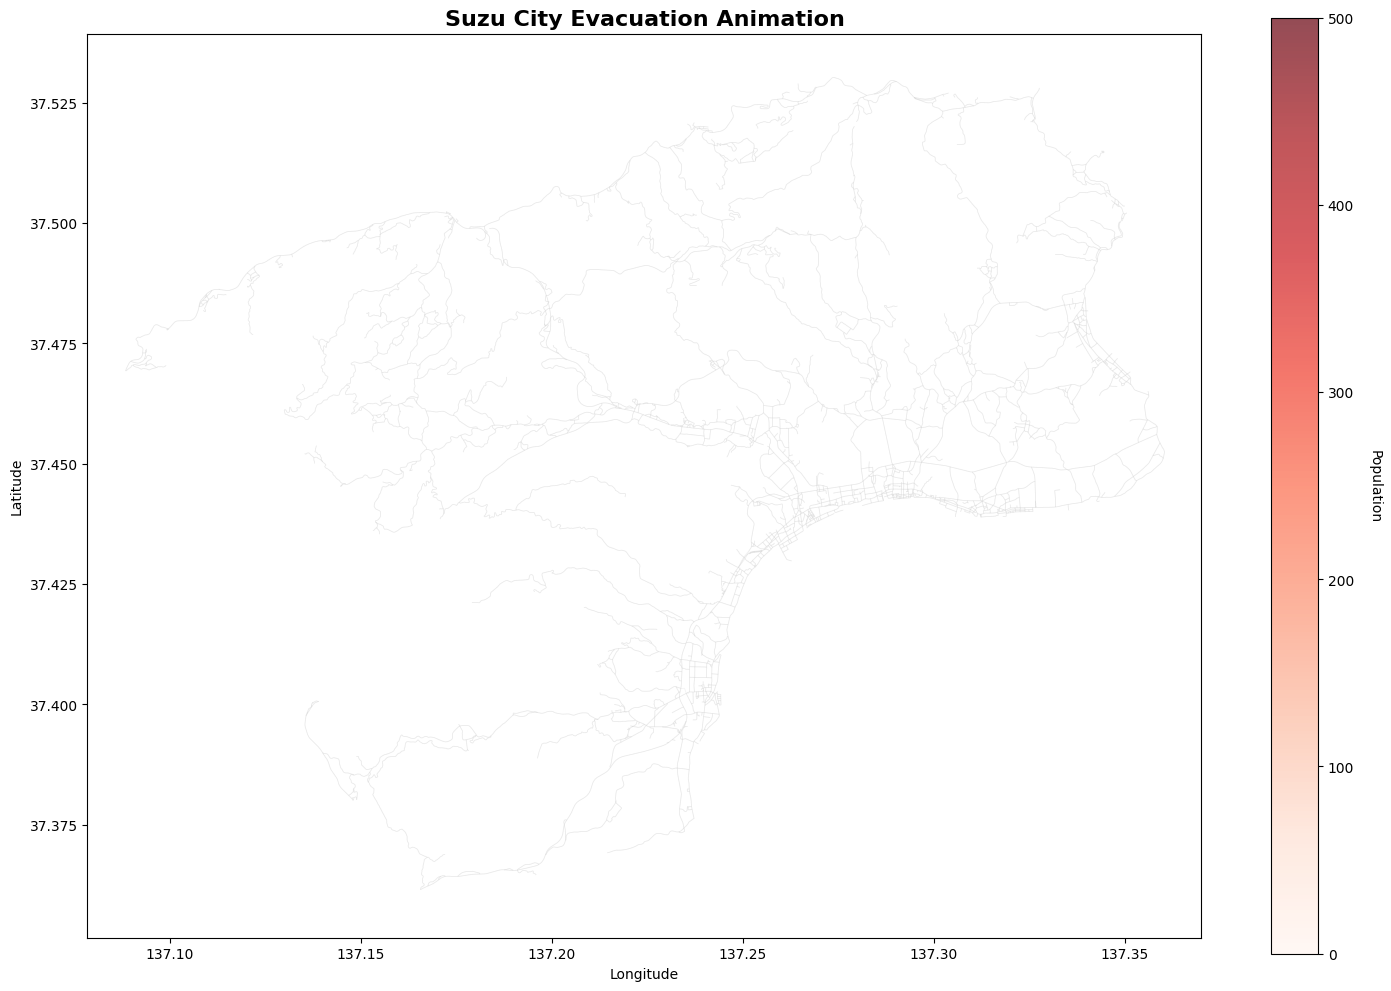


2. Creating interactive evacuation timeline...
Creating interactive evacuation timeline...



3. Creating 3D evacuation visualization...
Creating 3D evacuation visualization...



4. Saving evacuation animation...
Creating and saving evacuation animation as suzu_evacuation.gif...
Creating evacuation animation...
Animation saved as suzu_evacuation.gif

ANIMATION CREATION COMPLETE
Animation saved as suzu_evacuation.gif

ANIMATION CREATION COMPLETE


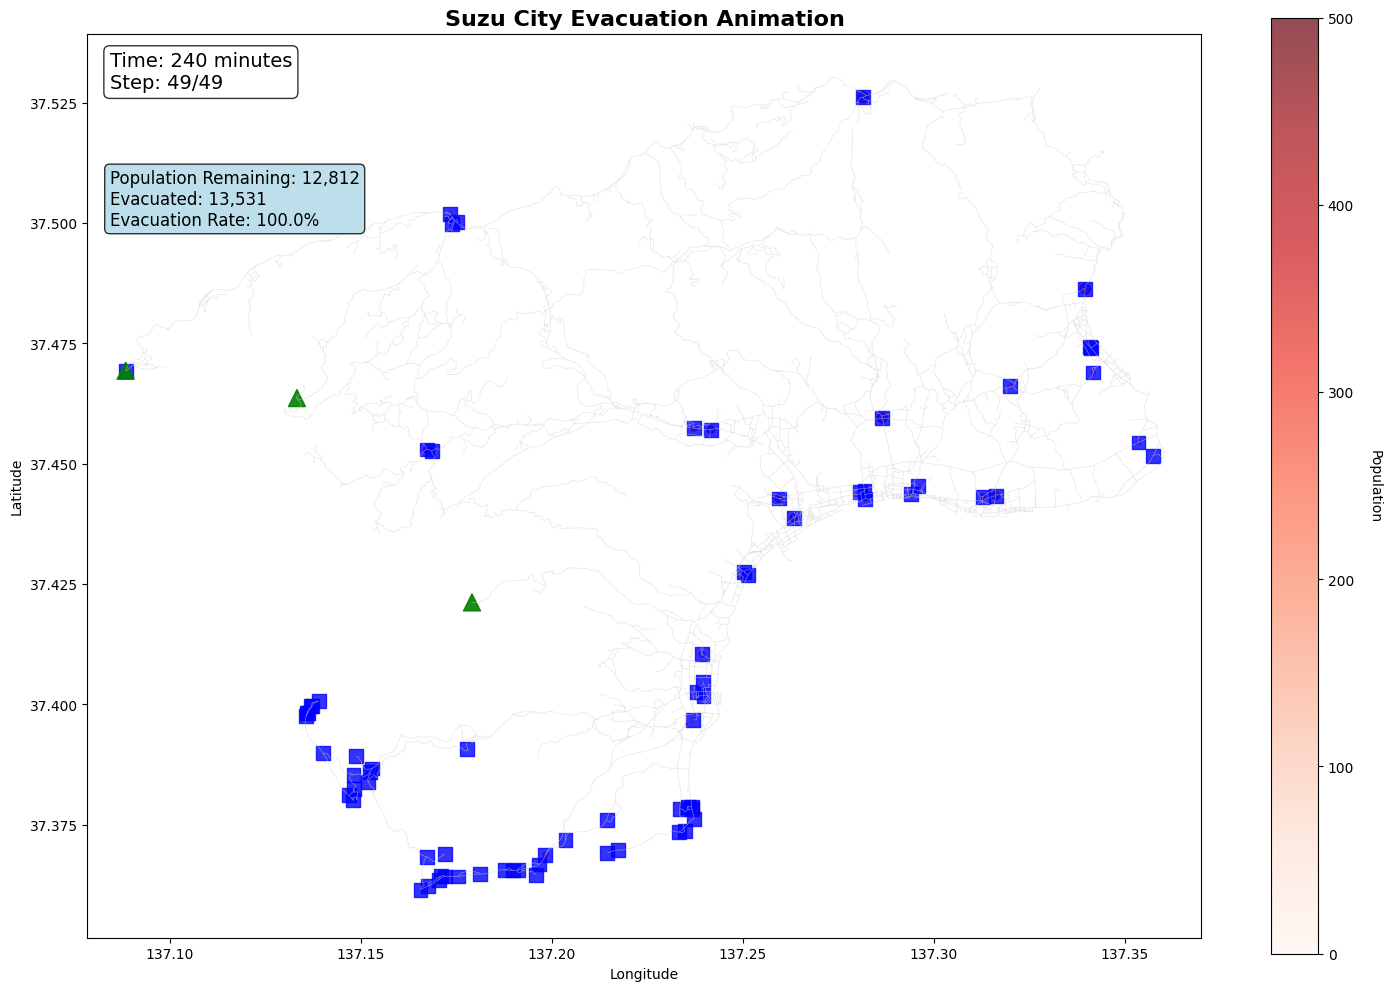

In [ ]:
def create_evacuation_animation(evacuation_result, nodes_data, edges_data, params):
    """Create an animated visualization of the evacuation process over time."""
    if evacuation_result is None:
        print("No evacuation results available for animation")
        return
    
    print("Creating evacuation animation...")
    
    # Extract flow data from results
    flow_dict = evacuation_result['flow_dict']
    ten = evacuation_result['time_expanded_network']
    
    # Process flow data by time steps
    flow_by_time = {}
    node_population_by_time = {}
    edge_flow_by_time = {}
    cumulative_evacuated_by_time = {}  # Track cumulative evacuations
    
    # Initialize data structures
    max_time = ten.time_steps
    for t in range(max_time):
        flow_by_time[t] = {}
        node_population_by_time[t] = {}
        edge_flow_by_time[t] = {}
        cumulative_evacuated_by_time[t] = 0
        
        # Initialize all nodes with their original population at t=0
        for node_id in nodes_data.index:
            if t == 0:
                node_population_by_time[t][node_id] = nodes_data.loc[node_id, 'population']
            else:
                node_population_by_time[t][node_id] = node_population_by_time[t-1][node_id]
    
    # Calculate cumulative evacuations by processing flows to super_sink
    super_sink = "super_sink"
    for source_node, targets in flow_dict.items():
        if super_sink in targets and targets[super_sink] > 0:
            if source_node in ten.reverse_mapping:
                _, time_step = ten.reverse_mapping[source_node]
                if time_step < max_time:
                    cumulative_evacuated_by_time[time_step] += targets[super_sink]
    
    # Convert to cumulative values
    total_evacuated = 0
    for t in range(max_time):
        total_evacuated += cumulative_evacuated_by_time[t]
        cumulative_evacuated_by_time[t] = total_evacuated
    
    # Process flow data for node population tracking
    for source, targets in flow_dict.items():
        for target, flow in targets.items():
            if flow > 0 and source in ten.reverse_mapping and target in ten.reverse_mapping:
                source_orig, source_time = ten.reverse_mapping[source]
                target_orig, target_time = ten.reverse_mapping[target]
                
                # Track node population changes
                if source_time < max_time and target_time < max_time:
                    # People leave source node
                    if source_time < max_time - 1:  # Ensure we don't go beyond bounds
                        for future_t in range(source_time + 1, max_time):
                            node_population_by_time[future_t][source_orig] -= flow
                    
                    # People arrive at target node (if it's not an exit)
                    if not (nodes_data.loc[target_orig, 'is_west_exit'] or 
                           nodes_data.loc[target_orig, 'is_south_exit'] or 
                           nodes_data.loc[target_orig, 'is_west_south_exit']):
                        if target_time < max_time - 1:  # Ensure we don't go beyond bounds
                            for future_t in range(target_time, max_time):
                                node_population_by_time[future_t][target_orig] += flow
                    
                    # Track edge flows
                    if source_orig != target_orig:  # Not a holding edge
                        edge_key = (source_orig, target_orig)
                        if edge_key not in edge_flow_by_time[source_time]:
                            edge_flow_by_time[source_time][edge_key] = 0
                        edge_flow_by_time[source_time][edge_key] += flow
    
    # Create the animation
    fig, ax = plt.subplots(figsize=(15, 12))
    
    # Setup base map
    edges_data.plot(ax=ax, linewidth=0.5, alpha=0.3, color='lightgray')
    
    # Initialize empty plots for dynamic elements
    population_scatter = ax.scatter([], [], s=[], c=[], cmap='Reds', alpha=0.7, vmin=0, vmax=500)
    shelter_scatter = ax.scatter([], [], s=[], c='blue', marker='s', alpha=0.8)
    exit_scatter = ax.scatter([], [], s=[], c='green', marker='^', alpha=0.9)
    
    # Add flow lines (will be updated in animation)
    flow_lines = []
    
    # Set up axis
    ax.set_xlim(nodes_data.geometry.x.min() - 0.01, nodes_data.geometry.x.max() + 0.01)
    ax.set_ylim(nodes_data.geometry.y.min() - 0.01, nodes_data.geometry.y.max() + 0.01)
    ax.set_title('Suzu City Evacuation Animation', fontsize=16, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Add colorbar
    cbar = plt.colorbar(population_scatter, ax=ax, shrink=0.8)
    cbar.set_label('Population', rotation=270, labelpad=20)
    
    # Add time display
    time_text = ax.text(0.02, 0.98, '', transform=ax.transAxes, fontsize=14, 
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add statistics display
    stats_text = ax.text(0.02, 0.85, '', transform=ax.transAxes, fontsize=12,
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    def animate(frame):
        """Animation function called for each frame."""
        current_time = frame
        time_minutes = current_time * params.time_step
        
        # Clear previous flow lines
        for line in flow_lines:
            line.remove()
        flow_lines.clear()
        
        # Update population nodes
        if current_time in node_population_by_time:
            node_populations = node_population_by_time[current_time]
            
            # Filter nodes with population > 0
            active_nodes = [(node_id, max(0, pop)) for node_id, pop in node_populations.items() if pop > 0]
            
            if active_nodes:
                node_ids, populations = zip(*active_nodes)
                x_coords = [nodes_data.loc[node_id, 'geometry'].x for node_id in node_ids]
                y_coords = [nodes_data.loc[node_id, 'geometry'].y for node_id in node_ids]
                
                # Update population scatter
                population_scatter.set_offsets(list(zip(x_coords, y_coords)))
                population_scatter.set_sizes([max(10, pop/20) for pop in populations])
                population_scatter.set_array(np.array(populations))
            else:
                population_scatter.set_offsets([])
                population_scatter.set_sizes([])
                population_scatter.set_array(np.array([]))
        
        # Update shelters (constant)
        shelters = nodes_data[nodes_data['is_shelter']]
        shelter_scatter.set_offsets(list(zip(shelters.geometry.x, shelters.geometry.y)))
        shelter_scatter.set_sizes([100] * len(shelters))
        
        # Update exits (constant)
        exits = nodes_data[nodes_data['is_west_exit'] | nodes_data['is_south_exit'] | nodes_data['is_west_south_exit']]
        exit_scatter.set_offsets(list(zip(exits.geometry.x, exits.geometry.y)))
        exit_scatter.set_sizes([150] * len(exits))
        
        # Add flow lines
        if current_time in edge_flow_by_time:
            for (source, target), flow in edge_flow_by_time[current_time].items():
                if source in nodes_data.index and target in nodes_data.index:
                    source_coords = nodes_data.loc[source, 'geometry']
                    target_coords = nodes_data.loc[target, 'geometry']
                    
                    # Line width proportional to flow
                    line_width = min(5, max(1, flow / 100))
                    
                    line = ax.plot([source_coords.x, target_coords.x], 
                                  [source_coords.y, target_coords.y], 
                                  'r-', linewidth=line_width, alpha=0.6)[0]
                    flow_lines.append(line)
        
        # Update time display
        time_text.set_text(f'Time: {time_minutes:3d} minutes\nStep: {current_time + 1}/{max_time}')
        
        # Update statistics using corrected calculation
        if current_time in node_population_by_time and current_time in cumulative_evacuated_by_time:
            # Calculate remaining population excluding shelters and exits
            total_remaining = 0
            for node_id, pop in node_population_by_time[current_time].items():
                if node_id in nodes_data.index:
                    # Skip shelters and exits when counting remaining population
                    if not (nodes_data.loc[node_id, 'is_shelter'] or 
                           nodes_data.loc[node_id, 'is_west_exit'] or 
                           nodes_data.loc[node_id, 'is_south_exit'] or 
                           nodes_data.loc[node_id, 'is_west_south_exit']):
                        total_remaining += max(0, pop)
            
            evacuated = cumulative_evacuated_by_time[current_time]
            evacuation_rate = (evacuated / evacuation_result['total_population']) * 100
            
            stats_text.set_text(f'Population Remaining: {total_remaining:,}\n'
                               f'Evacuated: {evacuated:,}\n'
                               f'Evacuation Rate: {evacuation_rate:.1f}%')
        
        return [population_scatter, shelter_scatter, exit_scatter, time_text, stats_text] + flow_lines
    
    # Create animation
    anim = FuncAnimation(fig, animate, frames=max_time, interval=500, blit=False, repeat=True)
    
    plt.tight_layout()
    return anim

def create_interactive_evacuation_timeline(evacuation_result, nodes_data, params):
    """Create an interactive timeline visualization using Plotly."""
    if evacuation_result is None:
        print("No evacuation results available for timeline")
        return
    
    print("Creating interactive evacuation timeline...")
    
    # Process flow data
    flow_dict = evacuation_result['flow_dict']
    ten = evacuation_result['time_expanded_network']
    
    # Calculate evacuated population by time step (incremental)
    evacuated_by_time = {}
    for t in range(ten.time_steps):
        evacuated_by_time[t] = 0
    
    # Process flow to sink (evacuated people)
    super_sink = "super_sink"
    for source_node, targets in flow_dict.items():
        if super_sink in targets and targets[super_sink] > 0:
            if source_node in ten.reverse_mapping:
                _, time_step = ten.reverse_mapping[source_node]
                if time_step < ten.time_steps:
                    evacuated_by_time[time_step] += targets[super_sink]
    
    # Calculate cumulative evacuated and remaining
    cumulative_evacuated = []
    remaining_population = []
    total_evacuated = 0
    
    for t in range(ten.time_steps):
        total_evacuated += evacuated_by_time[t]
        cumulative_evacuated.append(total_evacuated)
        remaining_population.append(evacuation_result['total_population'] - total_evacuated)
    
    # Create interactive plot
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Evacuation Progress', 'Flow Rate', 'Population Distribution', 'Evacuation Efficiency'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"type": "domain"}, {"secondary_y": False}]]
    )
    
    times = [t * params.time_step for t in range(ten.time_steps)]
    
    # Plot 1: Evacuation Progress
    fig.add_trace(
        go.Scatter(x=times, y=cumulative_evacuated,
                  mode='lines+markers', name='Cumulative Evacuated', line=dict(color='green')),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=times, y=remaining_population,
                  mode='lines+markers', name='Remaining', line=dict(color='red')),
        row=1, col=1
    )
    
    # Plot 2: Flow Rate (incremental evacuations per time step)
    flow_rates = [evacuated_by_time[t] for t in range(ten.time_steps)]
    fig.add_trace(
        go.Bar(x=times, y=flow_rates, name='Flow Rate', marker_color='blue'),
        row=1, col=2
    )
    
    # Plot 3: Population Distribution (pie chart at final time)
    final_evacuated = evacuation_result['flow_value']
    final_remaining = evacuation_result['total_population'] - final_evacuated
    
    fig.add_trace(
        go.Pie(labels=['Evacuated', 'Remaining'], values=[final_evacuated, final_remaining],
              marker_colors=['green', 'red']),
        row=2, col=1
    )
    
    # Plot 4: Evacuation Efficiency
    efficiency = [(evac / evacuation_result['total_population']) * 100 for evac in cumulative_evacuated]
    fig.add_trace(
        go.Scatter(x=times, y=efficiency, mode='lines+markers', name='Efficiency %', 
                  line=dict(color='purple')),
        row=2, col=2
    )
    
    # Update layout
    fig.update_layout(
        title_text=f"Suzu City Evacuation Timeline Analysis - {evacuation_result['evacuation_rate']:.1f}% Success Rate",
        showlegend=True,
        height=800
    )
    
    fig.update_xaxes(title_text="Time (minutes)", row=1, col=1)
    fig.update_xaxes(title_text="Time (minutes)", row=1, col=2)
    fig.update_xaxes(title_text="Time (minutes)", row=2, col=2)
    
    fig.update_yaxes(title_text="Population", row=1, col=1)
    fig.update_yaxes(title_text="People/Time Step", row=1, col=2)
    fig.update_yaxes(title_text="Efficiency (%)", row=2, col=2)
    
    fig.show()
    
    return fig

def create_3d_evacuation_visualization(evacuation_result, nodes_data, params):
    """Create a 3D visualization of the evacuation process."""
    if evacuation_result is None:
        print("No evacuation results available for 3D visualization")
        return
    
    print("Creating 3D evacuation visualization...")
    
    # Process flow data
    flow_dict = evacuation_result['flow_dict']
    ten = evacuation_result['time_expanded_network']
    
    # Create time-based population data using corrected logic
    time_steps = ten.time_steps
    node_populations = {}
    cumulative_evacuated_3d = {}
    
    # Initialize populations
    for t in range(time_steps):
        node_populations[t] = {}
        cumulative_evacuated_3d[t] = 0
        for node_id in nodes_data.index:
            if t == 0:
                node_populations[t][node_id] = nodes_data.loc[node_id, 'population']
            else:
                node_populations[t][node_id] = node_populations[t-1][node_id]
    
    # Calculate cumulative evacuations first
    super_sink = "super_sink"
    for source_node, targets in flow_dict.items():
        if super_sink in targets and targets[super_sink] > 0:
            if source_node in ten.reverse_mapping:
                _, time_step = ten.reverse_mapping[source_node]
                if time_step < time_steps:
                    cumulative_evacuated_3d[time_step] += targets[super_sink]
    
    # Convert to cumulative
    total_evac_3d = 0
    for t in range(time_steps):
        total_evac_3d += cumulative_evacuated_3d[t]
        cumulative_evacuated_3d[t] = total_evac_3d
    
    # Process flows for node population changes
    for source, targets in flow_dict.items():
        for target, flow in targets.items():
            if flow > 0 and source in ten.reverse_mapping and target in ten.reverse_mapping:
                source_orig, source_time = ten.reverse_mapping[source]
                target_orig, target_time = ten.reverse_mapping[target]
                
                if source_time < time_steps and target_time < time_steps:
                    # Update population for future time steps
                    for future_t in range(source_time + 1, time_steps):
                        if source_orig in node_populations[future_t]:
                            node_populations[future_t][source_orig] -= flow
                    
                    if not (nodes_data.loc[target_orig, 'is_west_exit'] or 
                           nodes_data.loc[target_orig, 'is_south_exit'] or 
                           nodes_data.loc[target_orig, 'is_west_south_exit']):
                        for future_t in range(target_time, time_steps):
                            if target_orig in node_populations[future_t]:
                                node_populations[future_t][target_orig] += flow
    
    # Create 3D plot data
    x_coords = []
    y_coords = []
    z_coords = []
    populations = []
    colors = []
    
    for t in range(0, time_steps, 2):  # Sample every 2 time steps for performance
        for node_id, pop in node_populations[t].items():
            if pop > 0:
                node_geom = nodes_data.loc[node_id, 'geometry']
                x_coords.append(node_geom.x)
                y_coords.append(node_geom.y)
                z_coords.append(t * params.time_step)  # Time as Z-axis
                populations.append(max(0, pop))
                colors.append(t)
    
    # Create 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(
        x=x_coords,
        y=y_coords,
        z=z_coords,
        mode='markers',
        marker=dict(
            size=[max(3, pop/50) for pop in populations],
            color=colors,
            colorscale='Viridis',
            colorbar=dict(title="Time Step"),
            opacity=0.6
        ),
        text=[f'Population: {pop}<br>Time: {z}min' for pop, z in zip(populations, z_coords)],
        hovertemplate='<b>Population:</b> %{text}<br><extra></extra>'
    )])
    
    # Add shelters
    shelters = nodes_data[nodes_data['is_shelter']]
    fig.add_trace(go.Scatter3d(
        x=shelters.geometry.x,
        y=shelters.geometry.y,
        z=[0] * len(shelters),  # At ground level
        mode='markers',
        marker=dict(size=10, color='blue', symbol='square'),
        name='Shelters',
        hovertemplate='<b>Shelter</b><br><extra></extra>'
    ))
    
    # Add exits
    exits = nodes_data[nodes_data['is_west_exit'] | nodes_data['is_south_exit'] | nodes_data['is_west_south_exit']]
    fig.add_trace(go.Scatter3d(
        x=exits.geometry.x,
        y=exits.geometry.y,
        z=[0] * len(exits),  # At ground level
        mode='markers',
        marker=dict(size=12, color='red', symbol='diamond'),
        name='Exits',
        hovertemplate='<b>Exit Point</b><br><extra></extra>'
    ))
    
    # Update layout
    fig.update_layout(
        title=f'3D Evacuation Visualization - Suzu City<br>{evacuation_result["evacuation_rate"]:.1f}% Success Rate',
        scene=dict(
            xaxis_title='Longitude',
            yaxis_title='Latitude',
            zaxis_title='Time (minutes)'
        ),
        width=1000,
        height=800
    )
    
    fig.show()
    return fig

# Run the animation and visualizations
if evacuation_result:
    print("\n" + "="*60)
    print("CREATING EVACUATION ANIMATIONS AND VISUALIZATIONS")
    print("="*60)
    
    # Create static animation
    print("\n1. Creating evacuation animation...")
    anim = create_evacuation_animation(evacuation_result, nodes, edges, params)
    plt.show()
    
    # Create interactive timeline
    print("\n2. Creating interactive evacuation timeline...")
    timeline_fig = create_interactive_evacuation_timeline(evacuation_result, nodes, params)
    
    # Create 3D visualization
    print("\n3. Creating 3D evacuation visualization...")
    viz_3d = create_3d_evacuation_visualization(evacuation_result, nodes, params)
    
    # Save animation (optional)
    print("\n4. Saving evacuation animation...")
    try:
        save_evacuation_animation(evacuation_result, nodes, edges, params, "suzu_evacuation.gif")
    except Exception as e:
        print(f"Could not save animation: {e}")
    
    print("\n" + "="*60)
    print("ANIMATION CREATION COMPLETE")
    print("="*60)
else:
    print("Cannot create animations - no evacuation results available")